In [2]:
import pickle
import random

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import plotly.express as px

import tensorflow as tf
from tensorflow import keras
from keras import regularizers

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Load the data about embeddings, labels and predictions

In [3]:
with open('data/yamnet_scores/yamnet_scores_2020.pickle', 'rb') as file:
    pred_scores_20 = pickle.load(file)

with open('data/yamnet_scores/yamnet_scores_2021.pickle', 'rb') as file:
    pred_scores_21 = pickle.load(file)

pred_score_* are dictionaries {filename: (prediction, embedding, spectrogram)}

In [4]:
[el.shape for el in list(pred_scores_20.values())[0]], [el.shape for el in list(pred_scores_21.values())[0]]

([TensorShape([63, 521]), TensorShape([63, 1024]), TensorShape([3072, 64])],
 [TensorShape([60, 521]), TensorShape([60, 1024]), TensorShape([2928, 64])])

prediction are shape (n_frames, n_classes), each element is the "probability" of the occurrence of the corresponding event (to the index)

embeddings are (n_frames, embedding_dim)

Load the real labels

In [5]:
df_20 = pd.read_csv('data/yamnet_foreground_labels_20.csv')
df_21 = pd.read_csv('data/yamnet_foreground_labels_21.csv')
df_20.head()

file  frame_number              label_0 label_1 label_2  \
0  fu_2jeb5yktarbeiyk.wav             3  Nature/Animals/Bird    None    None   
1  fu_2jeb5yktarbeiyk.wav             4  Nature/Animals/Bird    None    None   
2  fu_2jeb5yktarbeiyk.wav             5  Nature/Animals/Bird    None    None   
3  fu_2jeb5yktarbeiyk.wav             6  Nature/Animals/Bird    None    None   
4  fu_2jeb5yktarbeiyk.wav             7  Nature/Animals/Bird    None    None   

       predicted_label  
0  Environmental noise  
1  Environmental noise  
2  Environmental noise  
3               Animal  
4               Animal

In [6]:
real_classes_20 = np.unique(df_20[[col for col in df_20.columns if 'label_' in col]].values)
real_classes_21 = np.unique(df_21[[col for col in df_21.columns if 'label_' in col]].values)

real_classes = np.union1d(real_classes_20, real_classes_21)
real_classes

array(['Human/Cough', 'Human/Movement', 'Human/Movement/Steps',
       'Human/Music', 'Human/Voice', 'Industrial/Construction',
       'Industrial/Industry', 'Industrial/Vacuum',
       'Industrial/Ventilation', 'Nature/Animals', 'Nature/Animals/Bird',
       'Nature/Animals/Cat', 'Nature/Animals/Dog',
       'Nature/Elements/Water', 'Nature/Elements/Wind',
       'Nature/Vegetation', 'Noise', 'None', 'Nothing', 'Signals',
       'Signals/Alarm', 'Signals/Bells', 'Signals/Klaxon',
       'Signals/Siren', 'Things/Ball', 'Things/Blind', 'Things/Door',
       'Things/Movement', 'Things/Trolley', 'Transport/Motorized',
       'Transport/Motorized/Air', 'Transport/Motorized/Rail',
       'Transport/Motorized/Road', 'Transport/Non-motorized'],
      dtype=object)

we won't need 'None' class

In [7]:
real_classes = [el for el in real_classes if el != 'None']
real_classes

['Human/Cough',
 'Human/Movement',
 'Human/Movement/Steps',
 'Human/Music',
 'Human/Voice',
 'Industrial/Construction',
 'Industrial/Industry',
 'Industrial/Vacuum',
 'Industrial/Ventilation',
 'Nature/Animals',
 'Nature/Animals/Bird',
 'Nature/Animals/Cat',
 'Nature/Animals/Dog',
 'Nature/Elements/Water',
 'Nature/Elements/Wind',
 'Nature/Vegetation',
 'Noise',
 'Nothing',
 'Signals',
 'Signals/Alarm',
 'Signals/Bells',
 'Signals/Klaxon',
 'Signals/Siren',
 'Things/Ball',
 'Things/Blind',
 'Things/Door',
 'Things/Movement',
 'Things/Trolley',
 'Transport/Motorized',
 'Transport/Motorized/Air',
 'Transport/Motorized/Rail',
 'Transport/Motorized/Road',
 'Transport/Non-motorized']

Let's create the dataset

In [8]:
x_list, y_list, y_list_one_hot = [], [], []

for i, row in df_20.iterrows():
    filename = row['file']
    frame_n = row['frame_number']
    label_names = [row[lab] for lab in row.keys() if 'label_' in lab if row[lab] != 'None']

    x_list.append(pred_scores_20[filename][1][frame_n]) # embeddings are in the second position
    # this for statified folding
    lab_0 = 'Nothing' if len(label_names) == 0 else label_names[0]
    y_list.append(tf.constant(real_classes.index(lab_0)))
    # we must use one-hot encoding
    n_classes = len(real_classes)
    y_arr = np.zeros(n_classes)
    if len(label_names) == 0:
      y_arr[real_classes.index('Nothing')] = 1
    for lab in label_names:
        y_arr[real_classes.index(lab)] = 1
    y_list_one_hot.append(tf.constant(y_arr))

len(x_list), len(y_list), len(y_list_one_hot)

(14236, 14236, 14236)

In [9]:
for i, row in df_21.iterrows():
    filename = row['file']
    frame_n = row['frame_number']
    label_names = [row[lab] for lab in row.keys() if 'label_' in lab if row[lab] != 'None']

    x_list.append(pred_scores_21[filename][1][frame_n]) # embeddings are in the second position
    # this for statified folding
    lab_0 = 'Nothing' if len(label_names) == 0 else label_names[0]
    y_list.append(tf.constant(real_classes.index(lab_0)))
    # we must use one-hot encoding
    n_classes = len(real_classes)
    y_arr = np.zeros(n_classes)
    if len(label_names) == 0:
      y_arr[real_classes.index('Nothing')] = 1
    for lab in label_names:
        y_arr[real_classes.index(lab)] = 1
    y_list_one_hot.append(tf.constant(y_arr))

len(x_list), len(y_list), len(y_list_one_hot)

(28690, 28690, 28690)

Convert it to numpy arrays to use sklearn StratifiedKFold

In [10]:
x_arr = np.array([el.numpy() for el in x_list])
y_arr = np.array([el.numpy() for el in y_list])
x_arr.shape, y_arr.shape

((28690, 1024), (28690,))

In [11]:
pd.Series(y_arr).value_counts()

17    9237
10    6061
31    5001
4     1863
14    1534
5      764
26     735
13     725
3      506
12     349
8      321
6      280
20     265
1      176
19     158
30     140
2       94
11      61
28      58
22      56
27      48
21      44
7       41
25      34
15      30
16      23
29      21
18      20
32      19
23      15
0        8
24       2
9        1
dtype: int64

# Simple fine-tuning

We must remove class 9 because there is only one element

In [12]:
idx_to_remove = (y_arr == 9).nonzero()[0]
x_arr, y_arr = x_arr[y_arr != 9], y_arr[y_arr != 9]
x_list = [el for i, el in enumerate(x_list) if i != idx_to_remove]
y_list_one_hot = [el for i, el in enumerate(y_list_one_hot) if i != idx_to_remove]

class_counts = pd.Series(y_arr).value_counts()
class_counts

17    9237
10    6061
31    5001
4     1863
14    1534
5      764
26     735
13     725
3      506
12     349
8      321
6      280
20     265
1      176
19     158
30     140
2       94
11      61
28      58
22      56
27      48
21      44
7       41
25      34
15      30
16      23
29      21
18      20
32      19
23      15
0        8
24       2
dtype: int64

In [13]:
class_frequencies = class_counts / np.sum(class_counts.values)
class_frequencies

17    0.321970
10    0.211266
31    0.174318
4     0.064938
14    0.053470
5     0.026630
26    0.025620
13    0.025271
3     0.017637
12    0.012165
8     0.011189
6     0.009760
20    0.009237
1     0.006135
19    0.005507
30    0.004880
2     0.003277
11    0.002126
28    0.002022
22    0.001952
27    0.001673
21    0.001534
7     0.001429
25    0.001185
15    0.001046
16    0.000802
29    0.000732
18    0.000697
32    0.000662
23    0.000523
0     0.000279
24    0.000070
dtype: float64

Now we can train

In [14]:
n_splits = 1
#splitter = StratifiedKFold(n_splits=n_splits)
splitter = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2)

dropout_rate = 0.3
lr = 0.0005
patience = 15
hid_1, hid_2 = 1024, 512
epochs = 100

METRICS = [
      'accuracy'
]

# TODO check bias initialization
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics
#output_bias =
#output_bias = tf.keras.initializers.Constant(output_bias)

#results = []
#for fold, (train_ind, test_ind) in enumerate(splitter.split(x_arr, y_arr)):
fold, (train_ind, test_ind) = 0, next(splitter.split(x_arr, y_arr))

print(f"Starting fold {fold+1} out of {n_splits}")
train_x = tf.stack([x_list[i] for i in train_ind])
train_y = tf.stack([y_list_one_hot[i] for i in train_ind])
test_x = tf.stack([x_list[i] for i in test_ind])
test_y = tf.stack([y_list_one_hot[i] for i in test_ind])

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(hid_1, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(hid_2, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(len(real_classes), activation='sigmoid')#, bias_initializer=output_bias)
], name='model')
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                metrics=METRICS)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=patience,
                                            restore_best_weights=True)

history = model.fit(train_x,
                    train_y,
                    epochs=epochs,
                    validation_data=(test_x, test_y),
                    callbacks=callback)

#results.append((model.predict(test_x), test_y))

Starting fold 1 out of 1
Epoch 1/100
718/718 [==============================] - 33s 43ms/step - loss: 0.1972 - accuracy: 0.5240 - val_loss: 0.1010 - val_accuracy: 0.5457
Epoch 2/100
718/718 [==============================] - 29s 40ms/step - loss: 0.0915 - accuracy: 0.5423 - val_loss: 0.0853 - val_accuracy: 0.5460
Epoch 3/100
718/718 [==============================] - 32s 45ms/step - loss: 0.0837 - accuracy: 0.5486 - val_loss: 0.0831 - val_accuracy: 0.5457
Epoch 4/100
718/718 [==============================] - 32s 45ms/step - loss: 0.0809 - accuracy: 0.5530 - val_loss: 0.0794 - val_accuracy: 0.5586
Epoch 5/100
718/718 [==============================] - 30s 42ms/step - loss: 0.0793 - accuracy: 0.5551 - val_loss: 0.0788 - val_accuracy: 0.5533
Epoch 6/100
718/718 [==============================] - 35s 48ms/step - loss: 0.0784 - accuracy: 0.5581 - val_loss: 0.0782 - val_accuracy: 0.5568
Epoch 7/100
718/718 [==============================] - 28s 40ms/step - loss: 0.0774 - accuracy: 0.5607 - 

Save the model

In [15]:
folder = 'data/fine_tuning_results/'
model.save(folder + 'model.keras')

Tried with dropout only, it improves but not by much.

With dropout and regularization it works better, accuracies in 5 runs: .51, .58, .52, .59, .55

So let's try to analyze better the performances.

In [16]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix

In [17]:
def plot_metrics(history):
  metrics = ['loss', 'accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    else:
      plt.ylim([0,1])

    plt.legend()

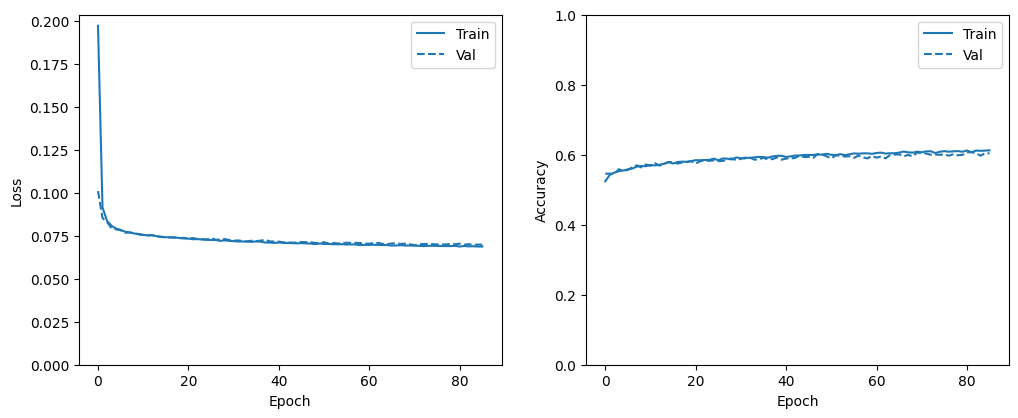

In [18]:
plot_metrics(history)

In [19]:
results = model.evaluate(test_x, test_y)

for name, value in zip(model.metrics_names, results):
  print(name, ': ', value)
print()

180/180 [==============================] - 2s 13ms/step - loss: 0.0695 - accuracy: 0.6040
loss :  0.06953694671392441
accuracy :  0.6040432453155518



In [20]:
test_predictions = model.predict(test_x)

180/180 [==============================] - 2s 9ms/step


In [21]:
def plot_cm(labels, predictions, threshold=0.5):
  pred_labels = predictions > threshold
  for label_name, cm in zip(real_classes, multilabel_confusion_matrix(test_y, pred_labels)):
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix for {} @{:.2f}'.format(label_name, threshold))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    plt.show()

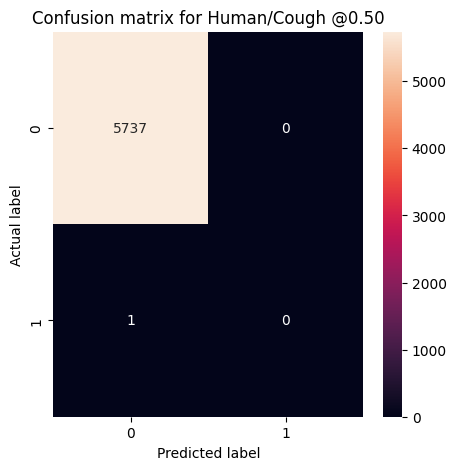

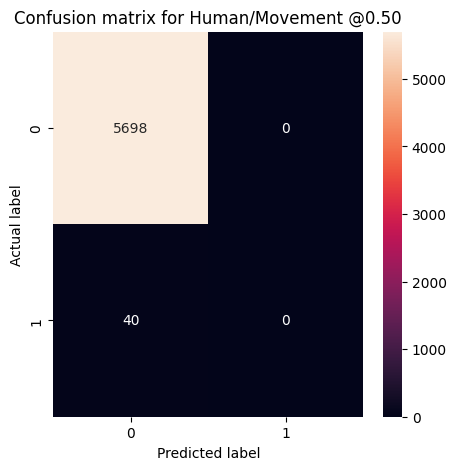

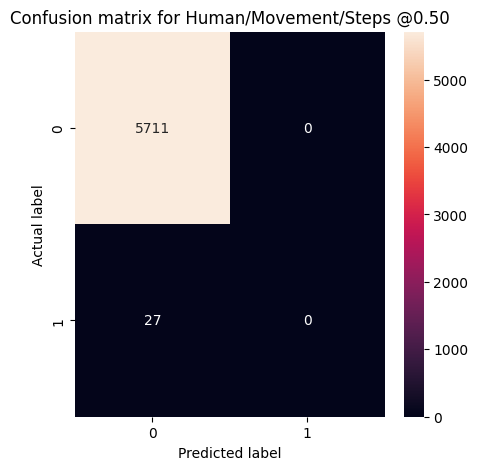

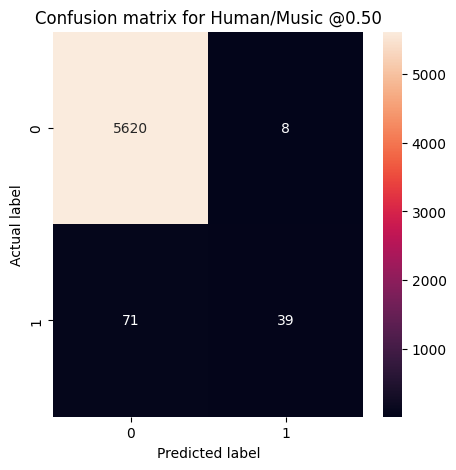

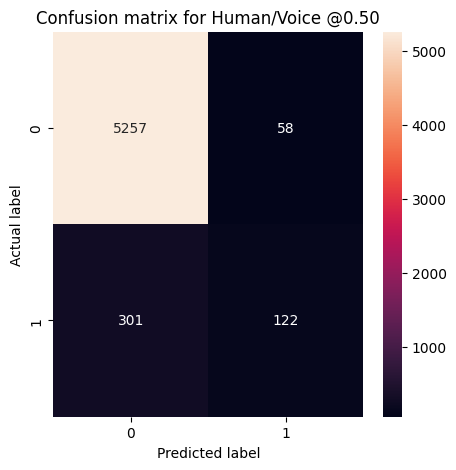

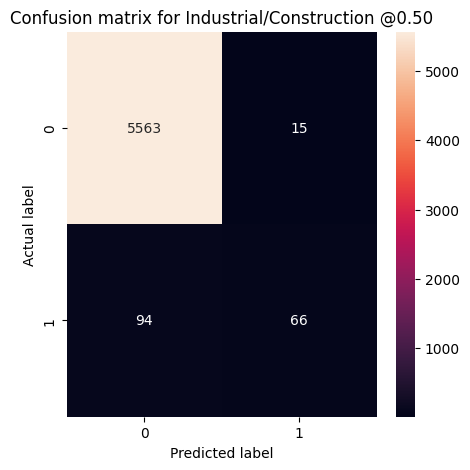

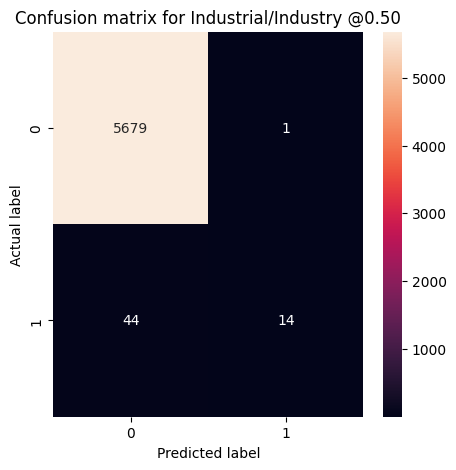

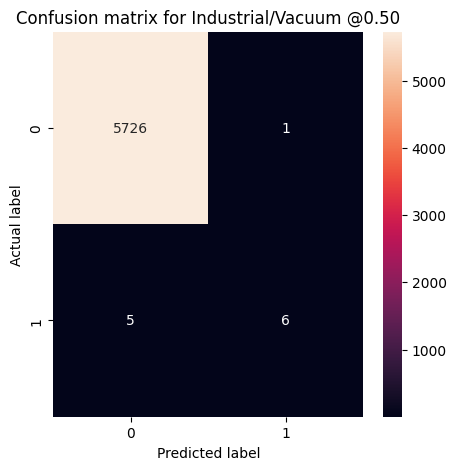

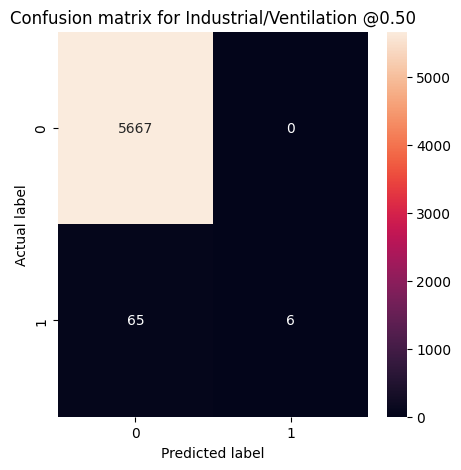

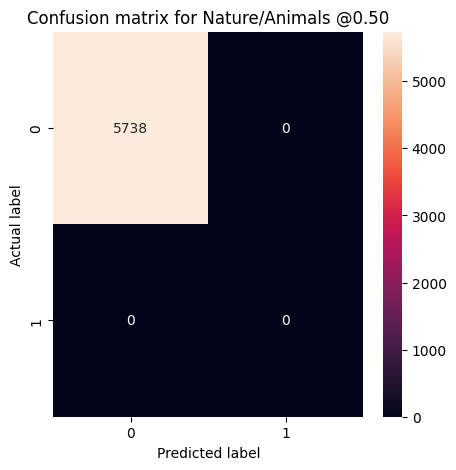

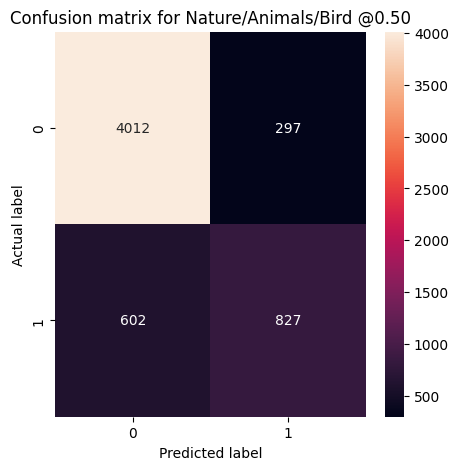

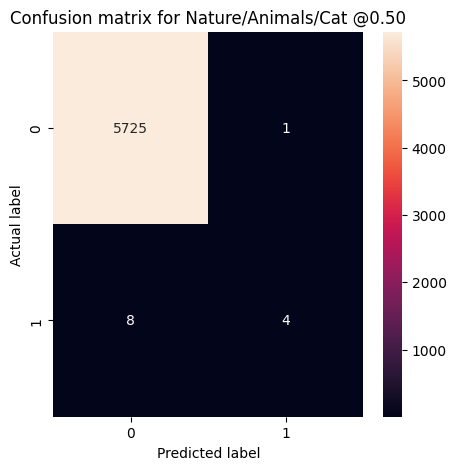

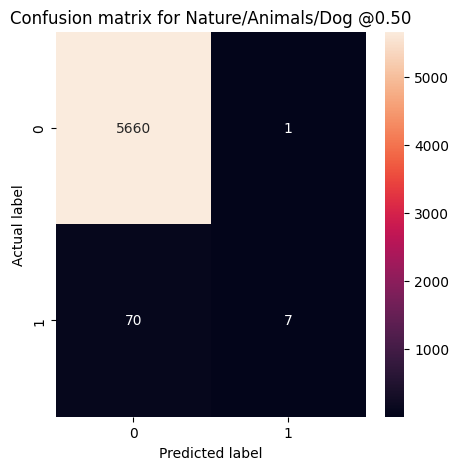

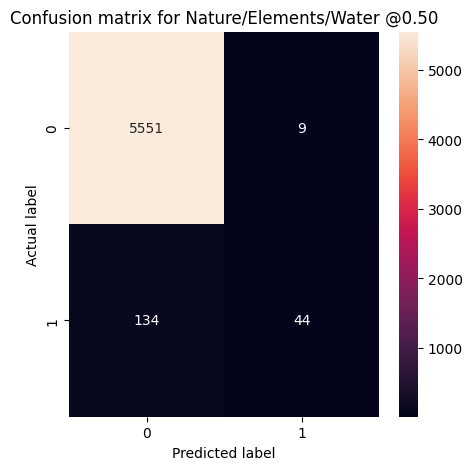

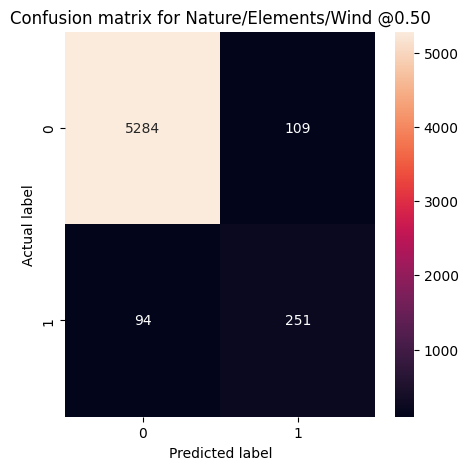

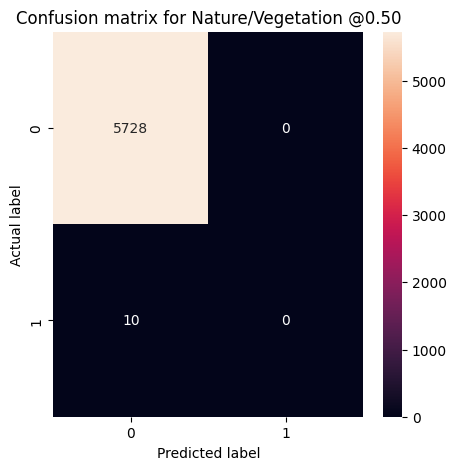

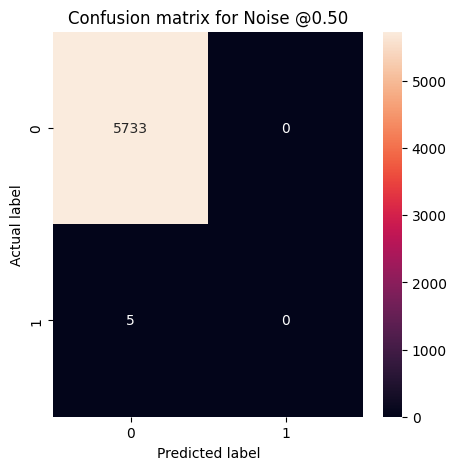

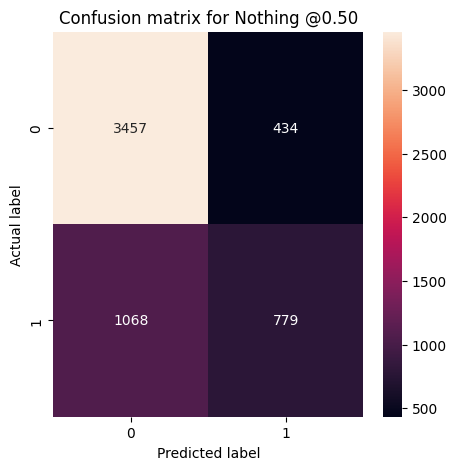

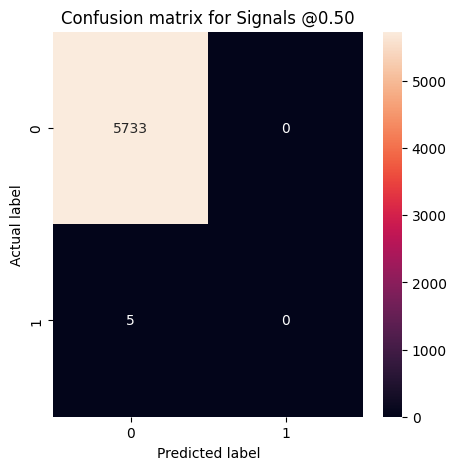

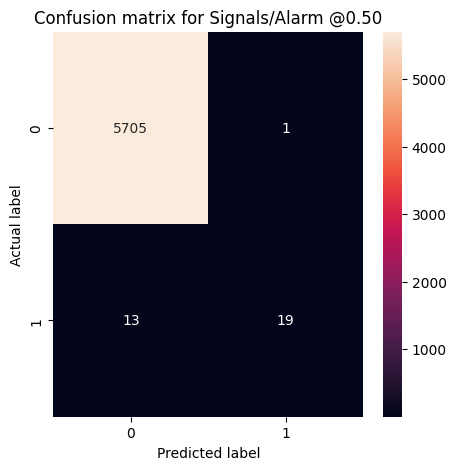

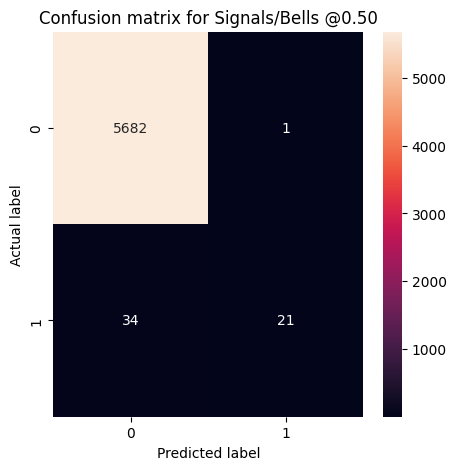

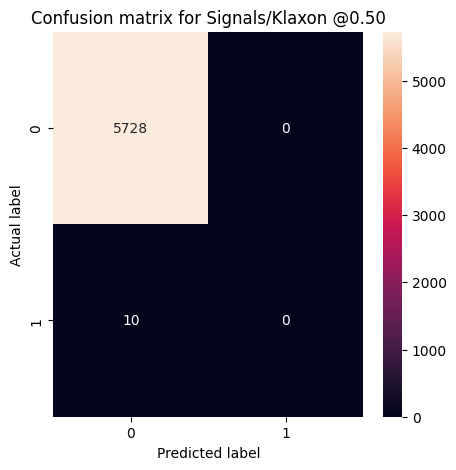

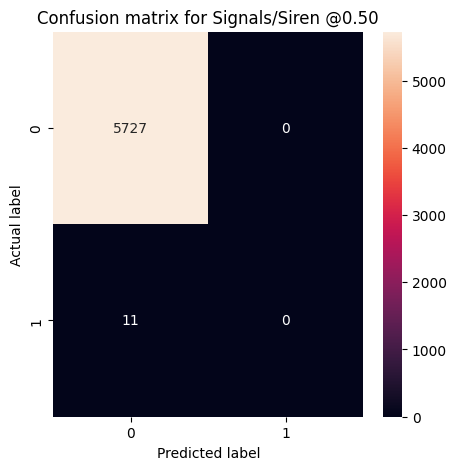

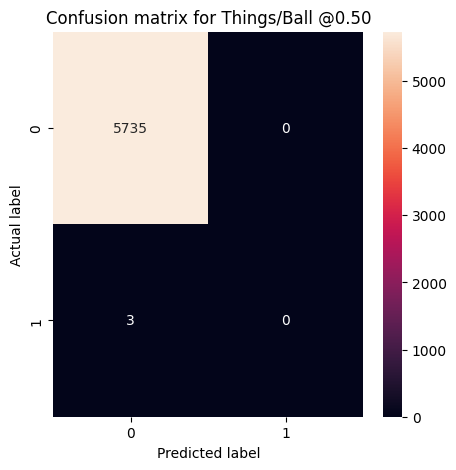

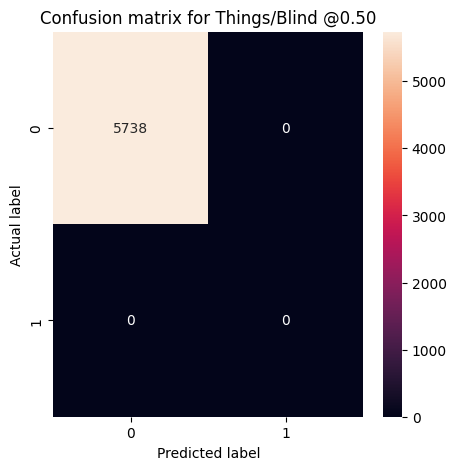

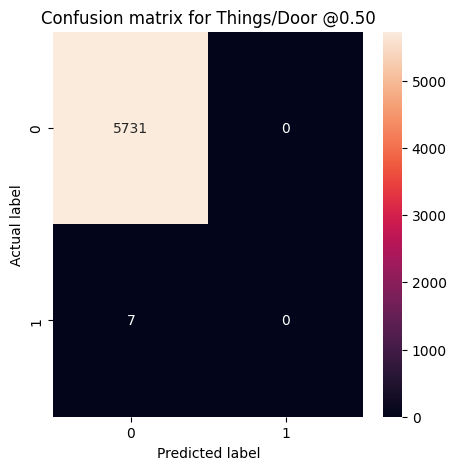

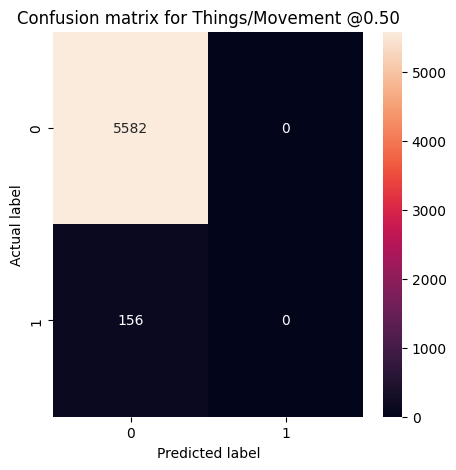

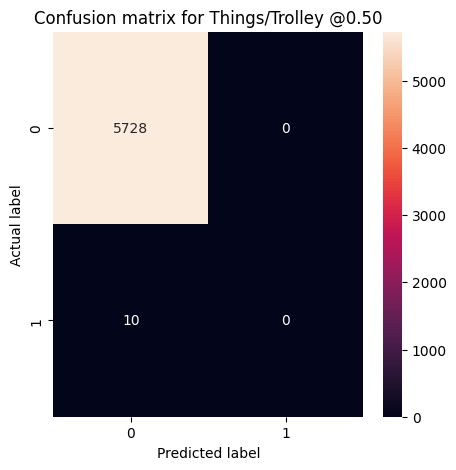

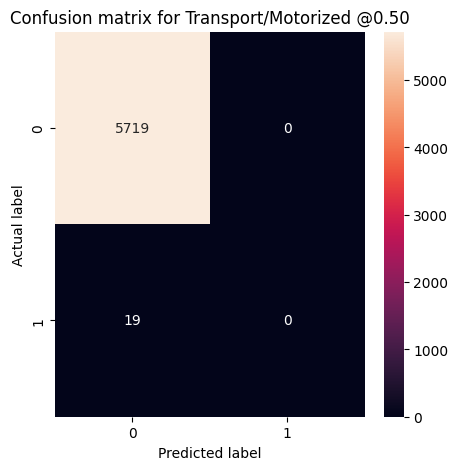

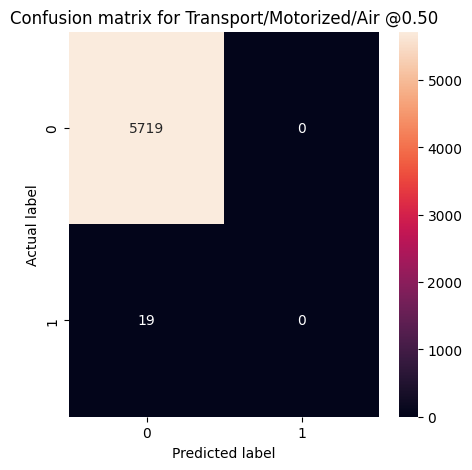

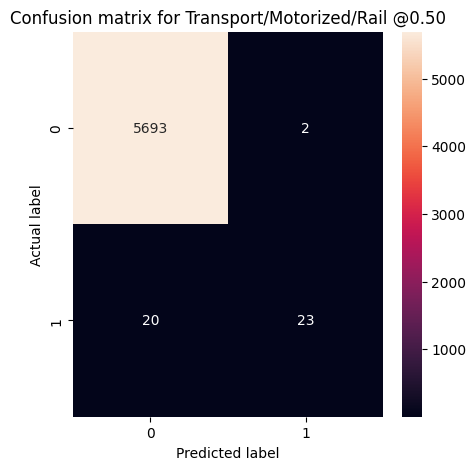

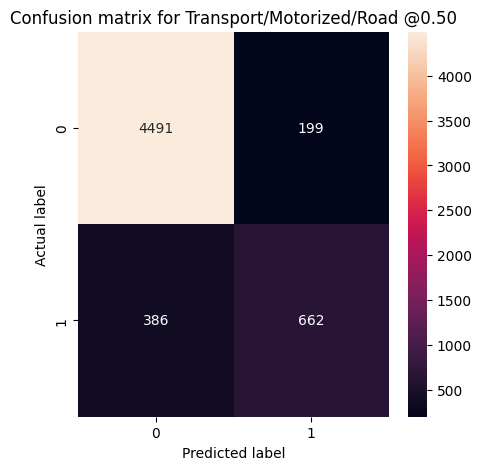

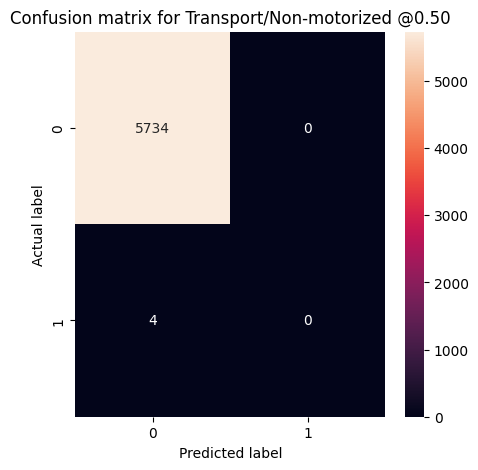

In [22]:
plot_cm(test_y, test_predictions)

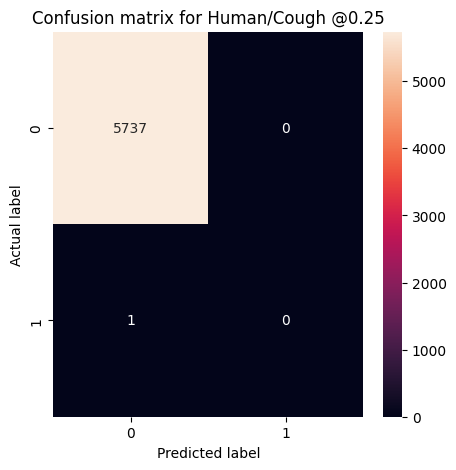

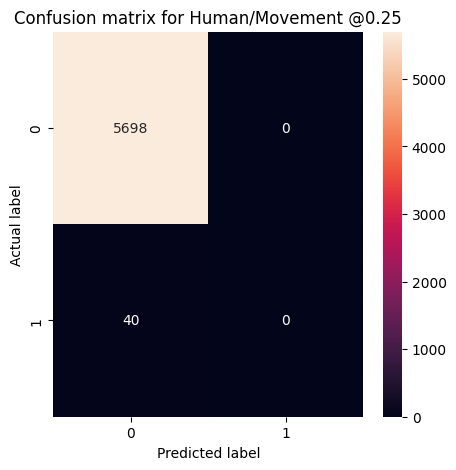

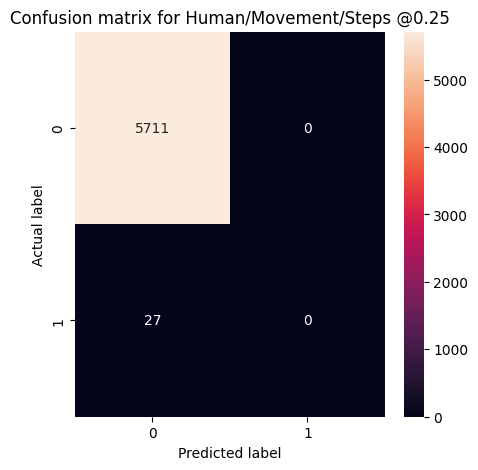

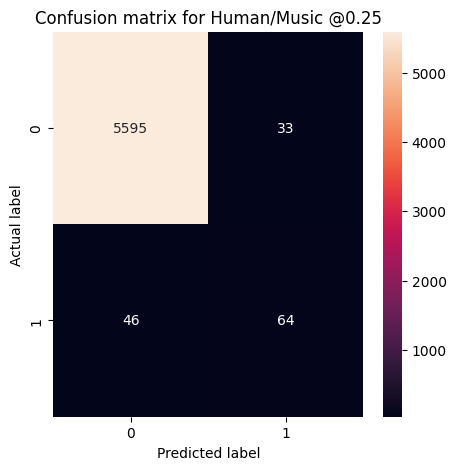

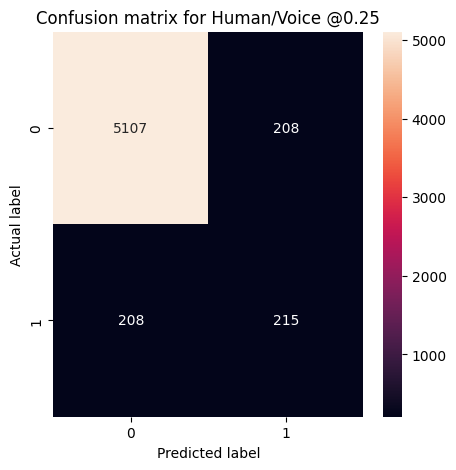

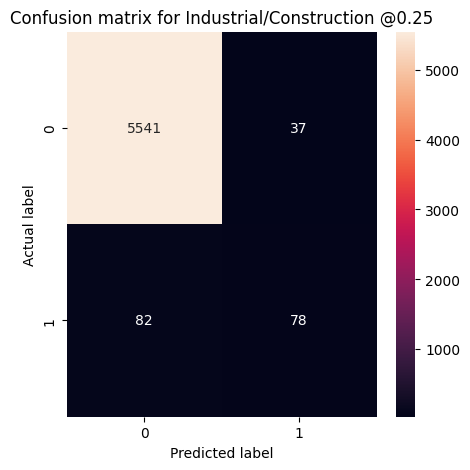

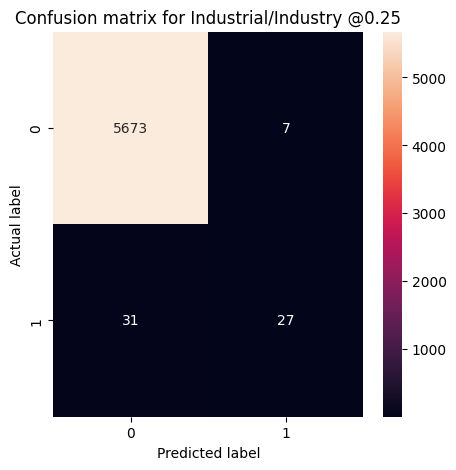

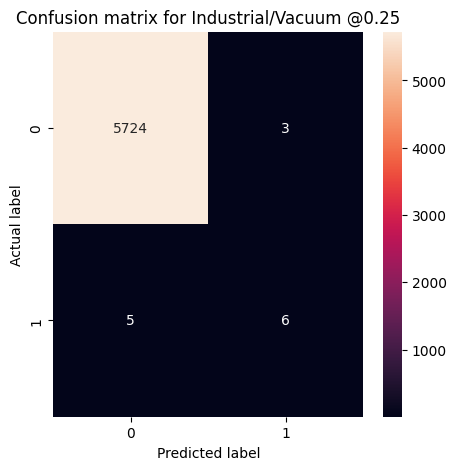

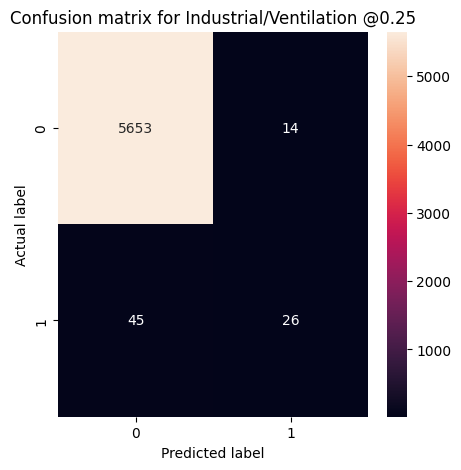

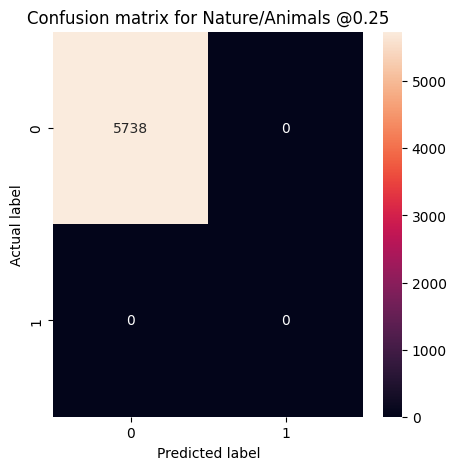

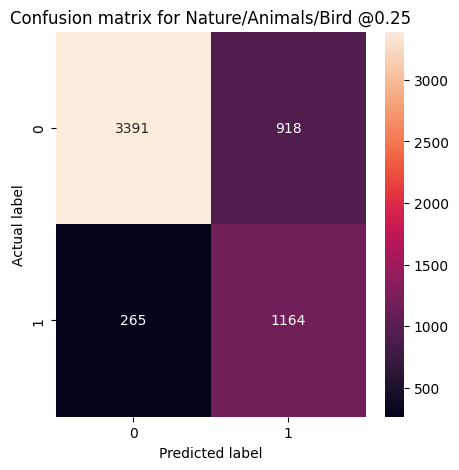

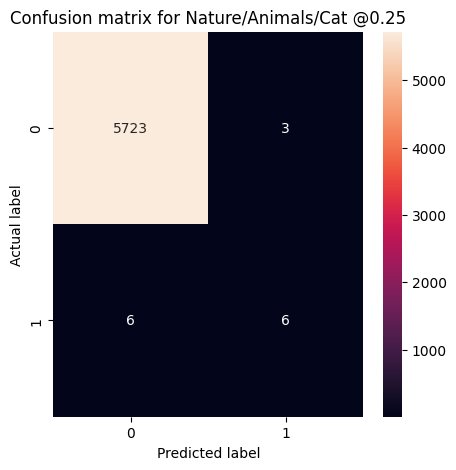

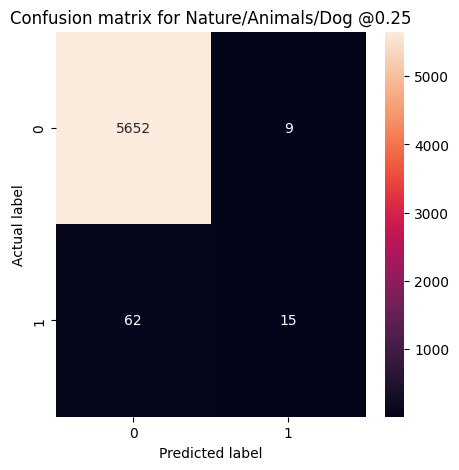

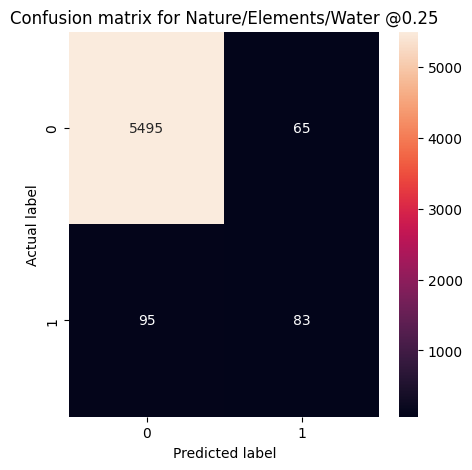

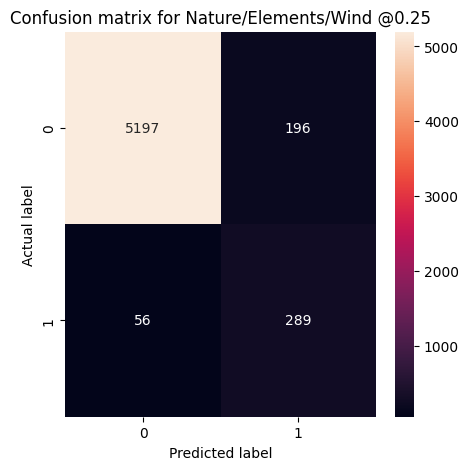

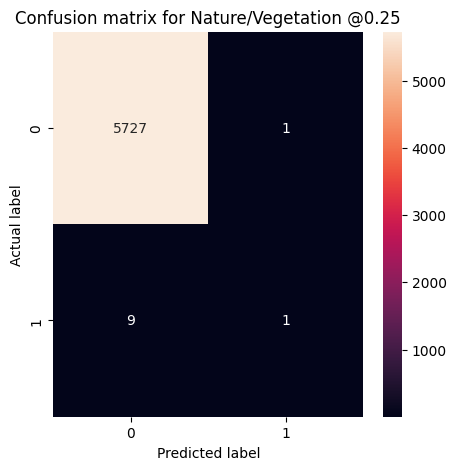

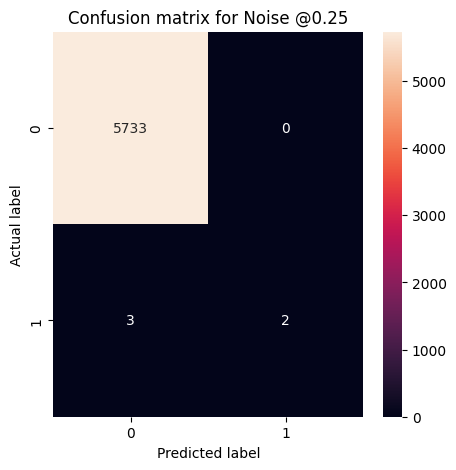

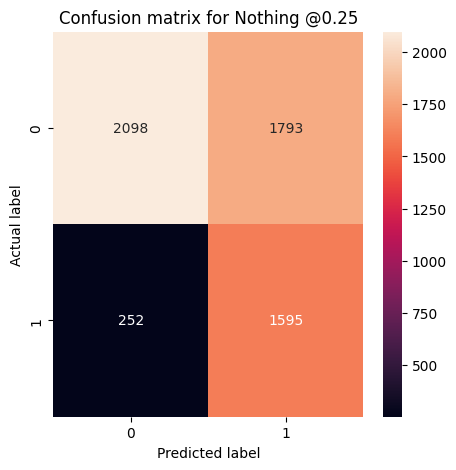

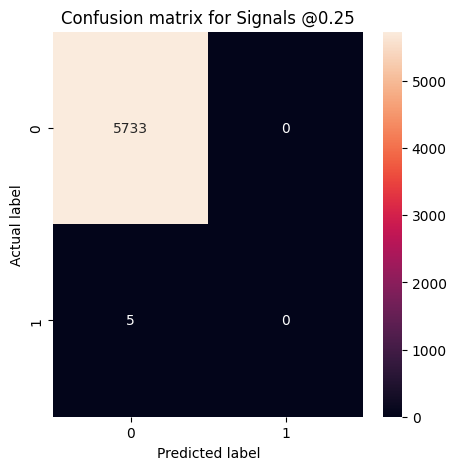

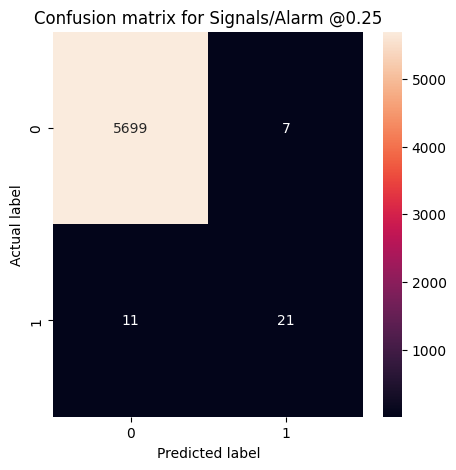

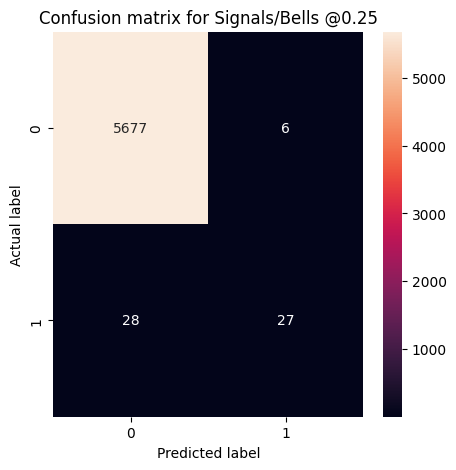

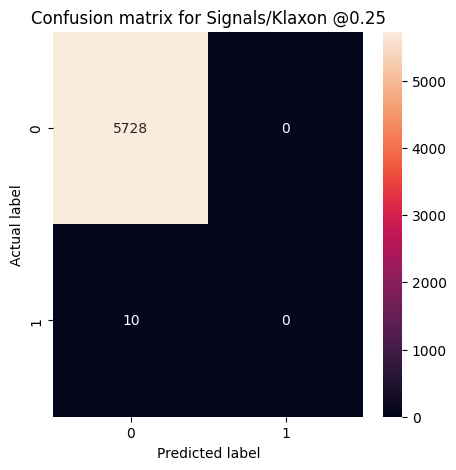

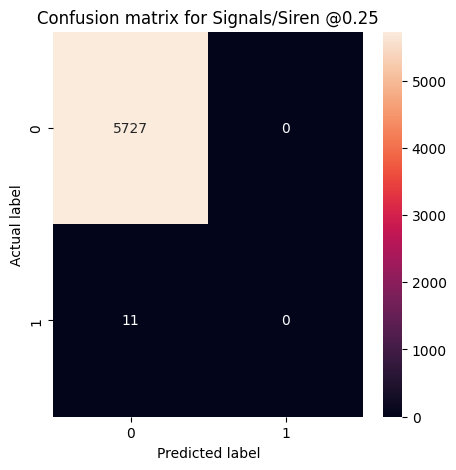

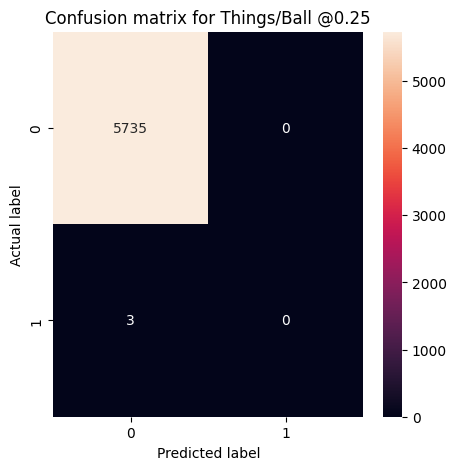

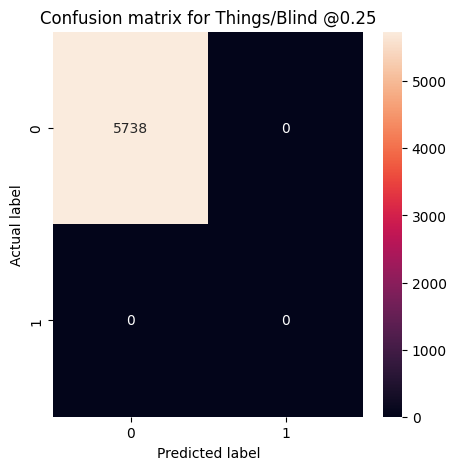

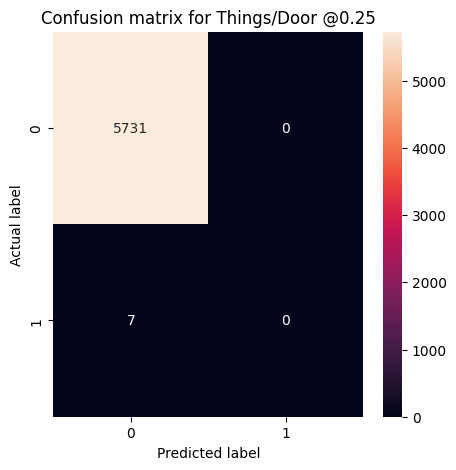

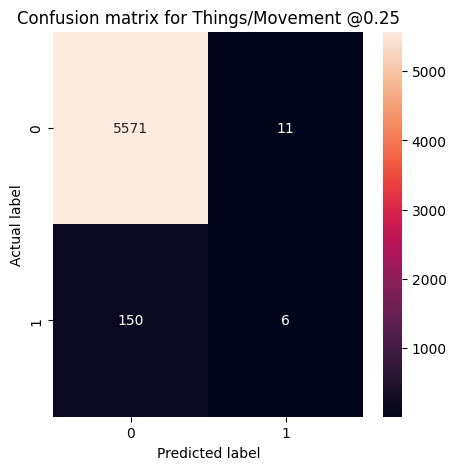

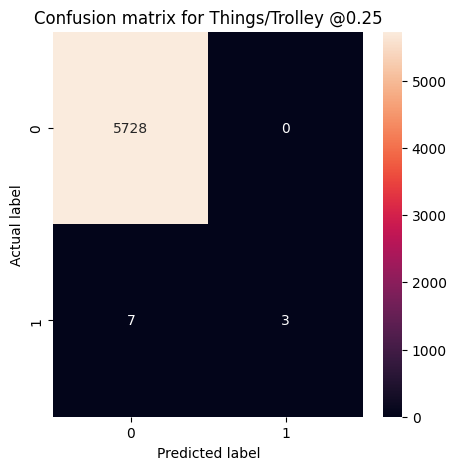

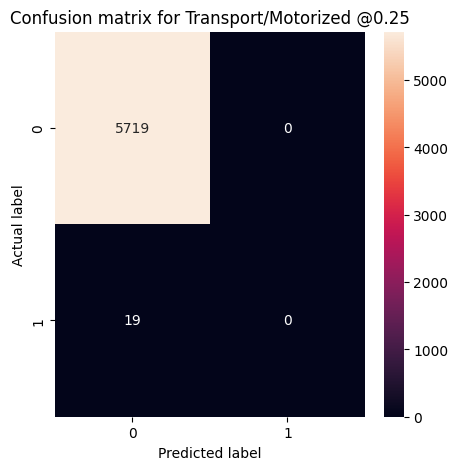

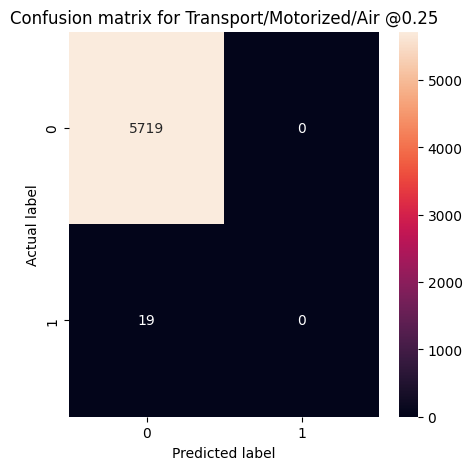

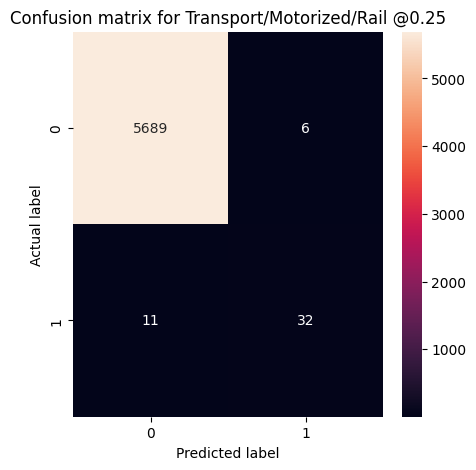

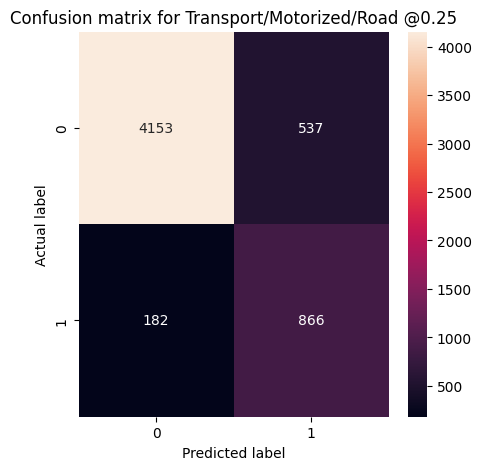

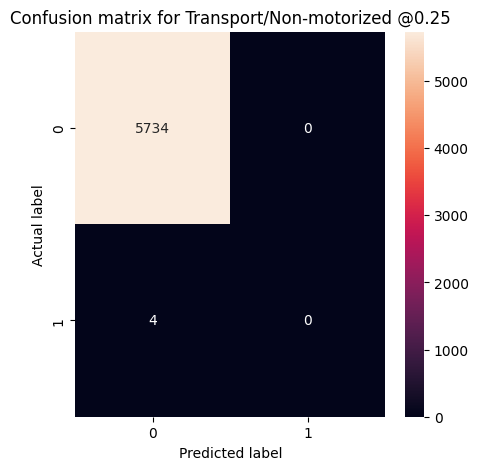

In [23]:
plot_cm(test_y, test_predictions, 0.25)

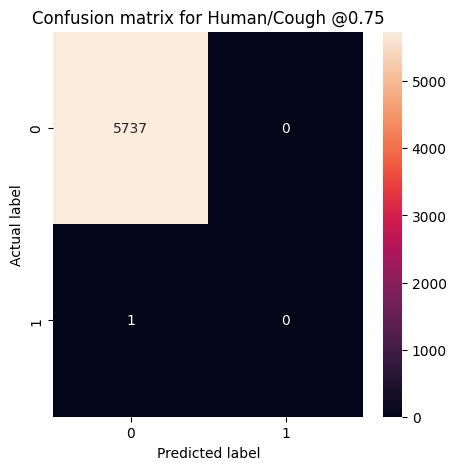

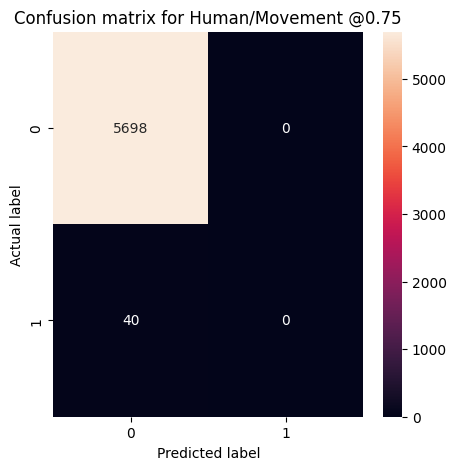

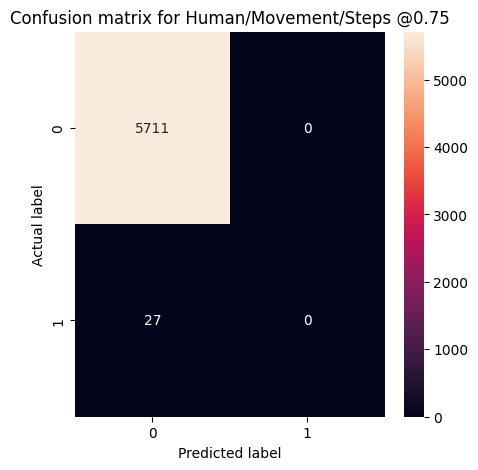

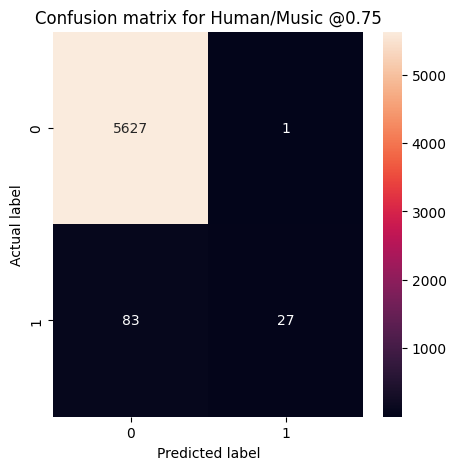

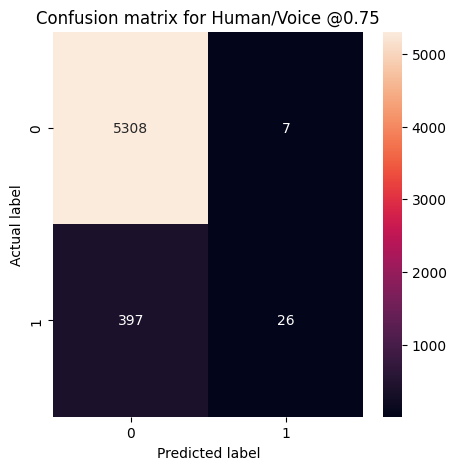

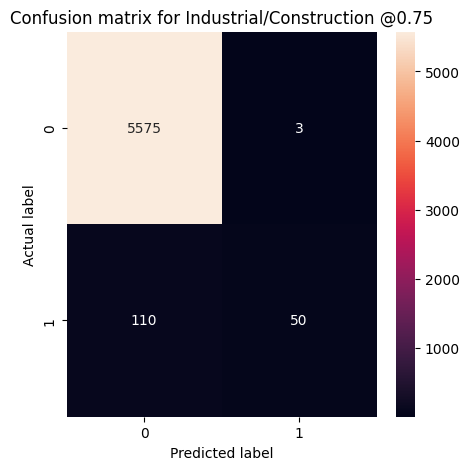

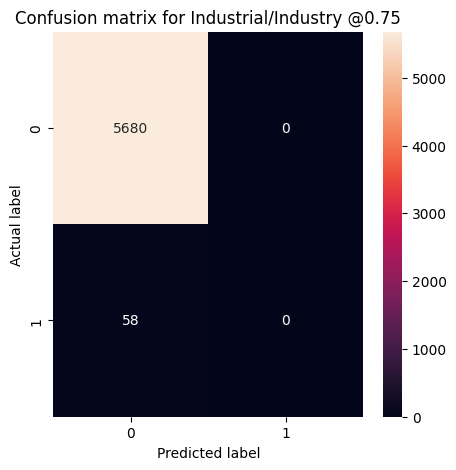

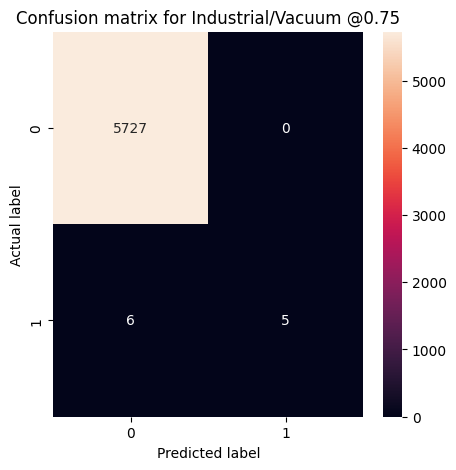

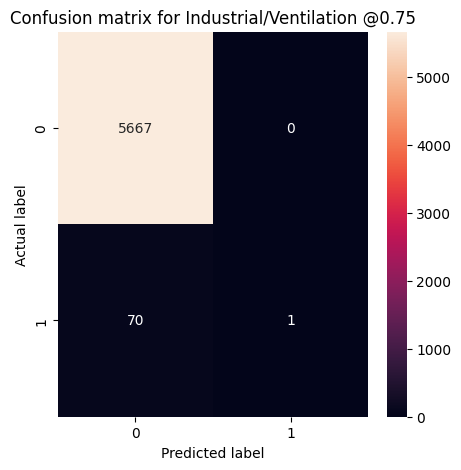

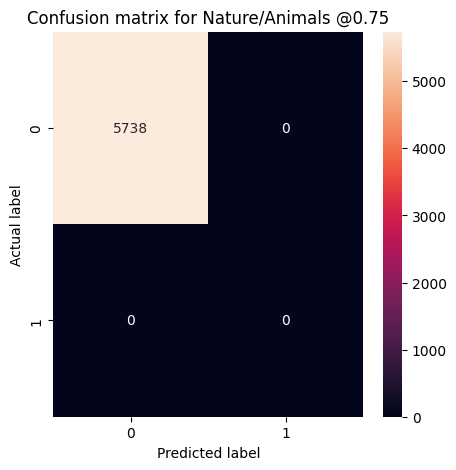

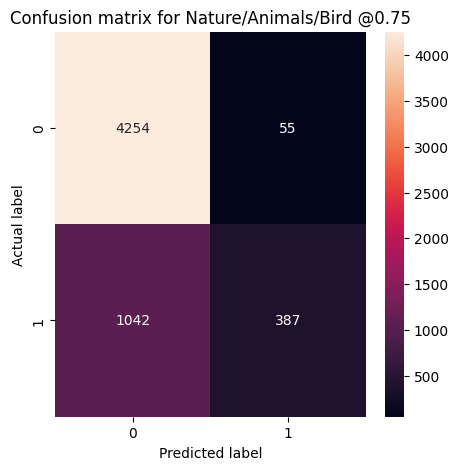

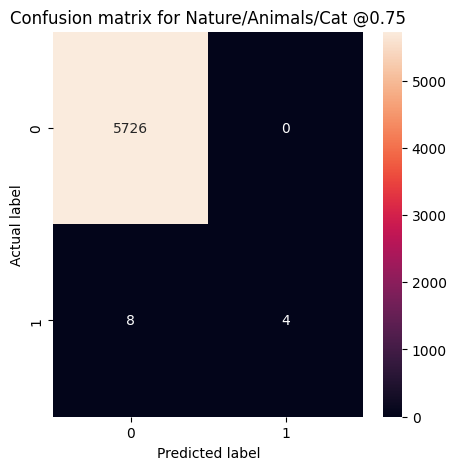

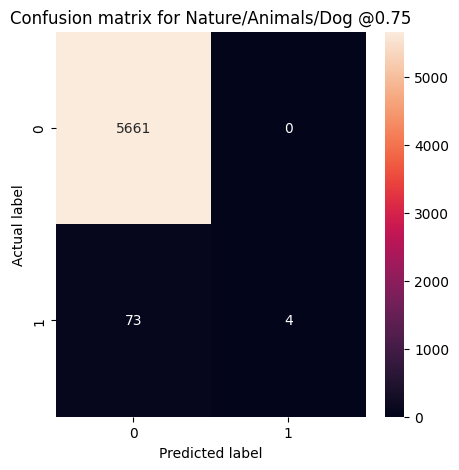

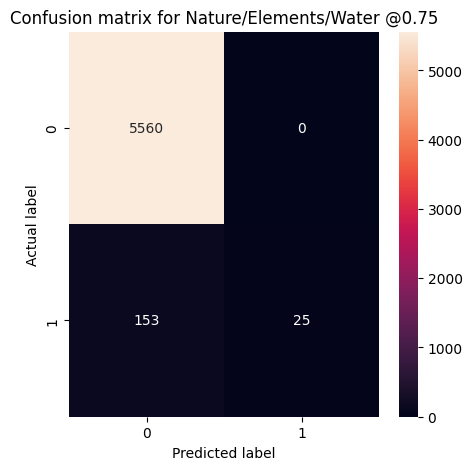

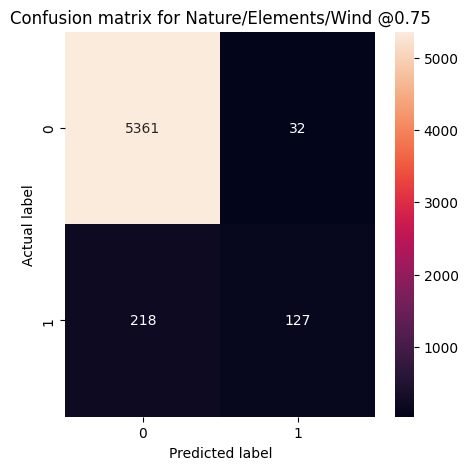

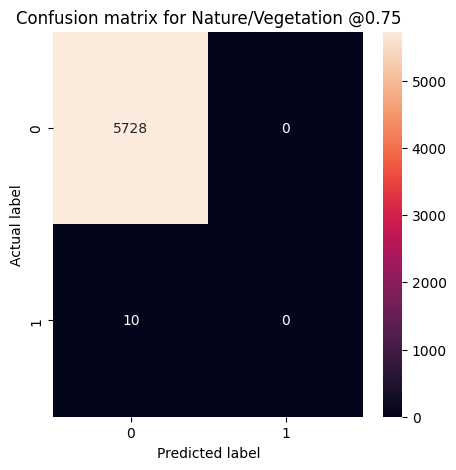

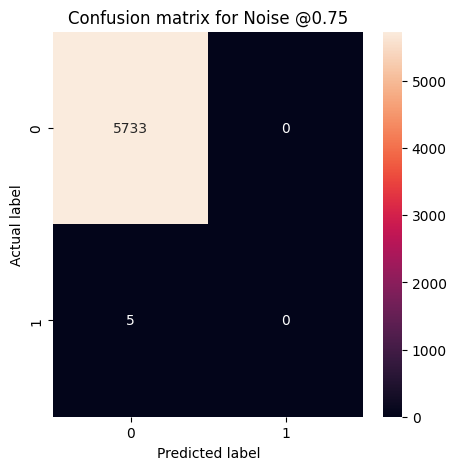

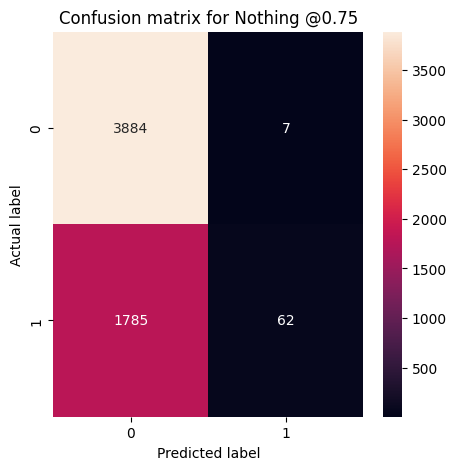

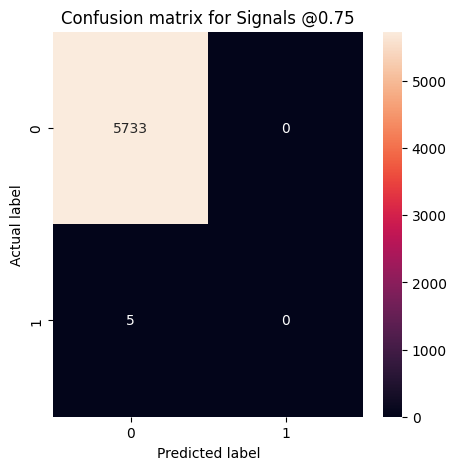

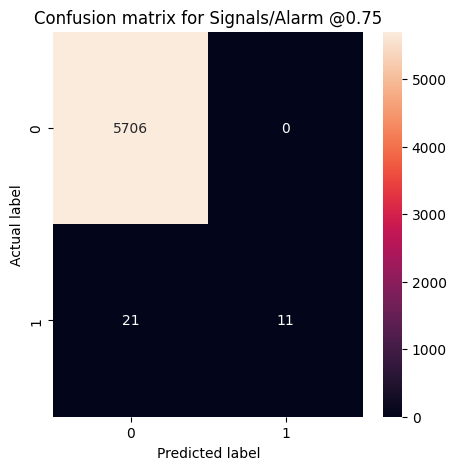

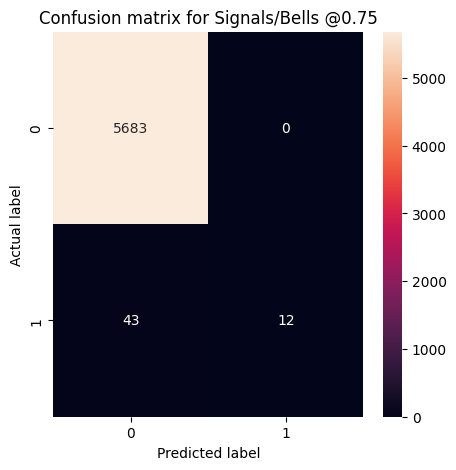

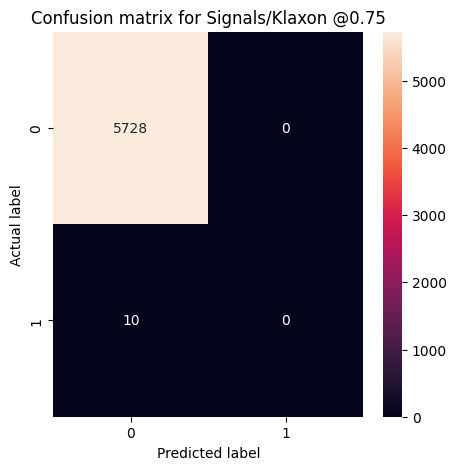

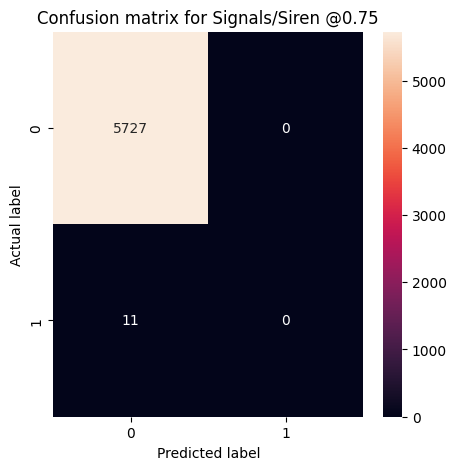

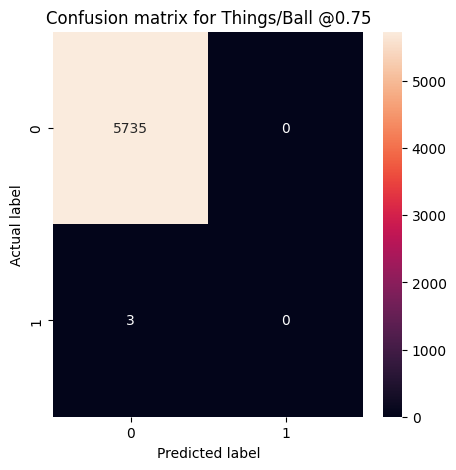

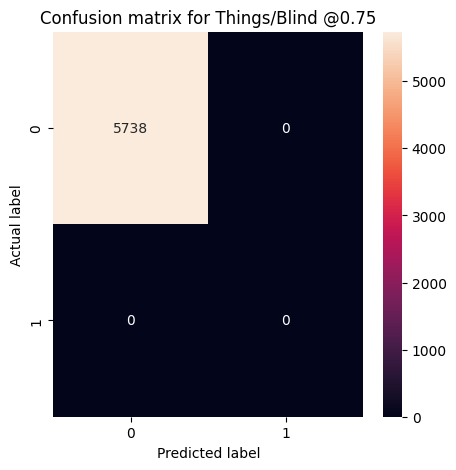

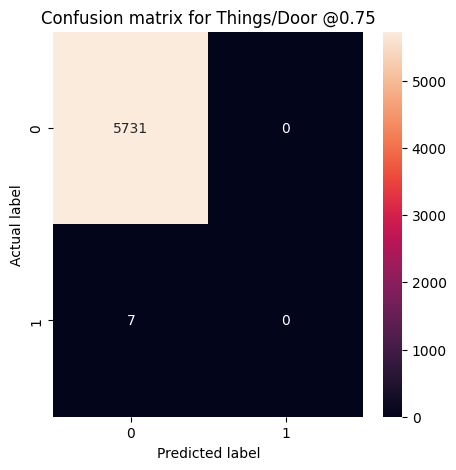

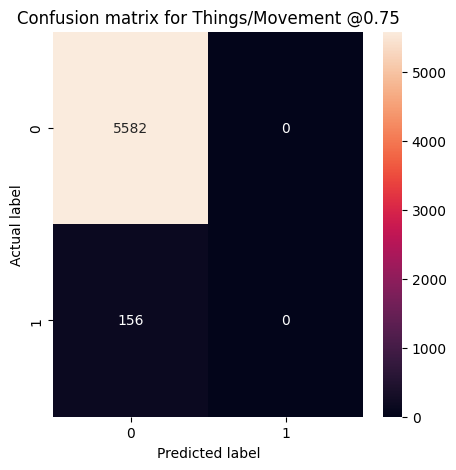

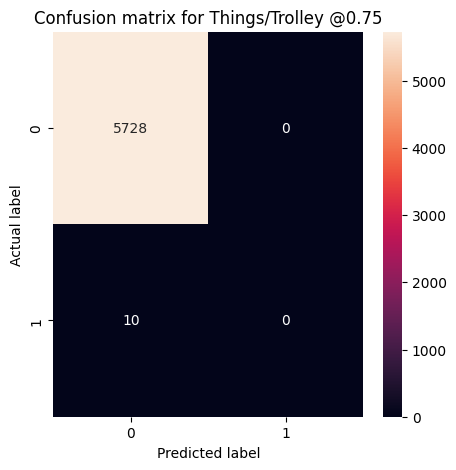

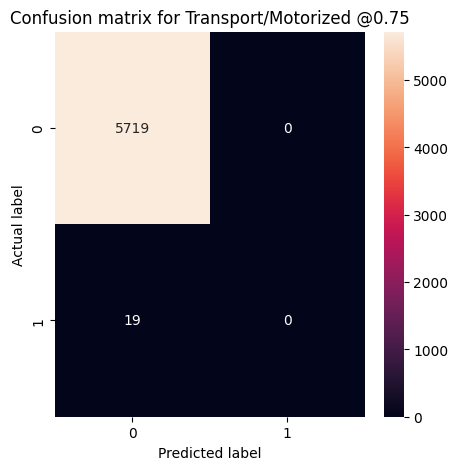

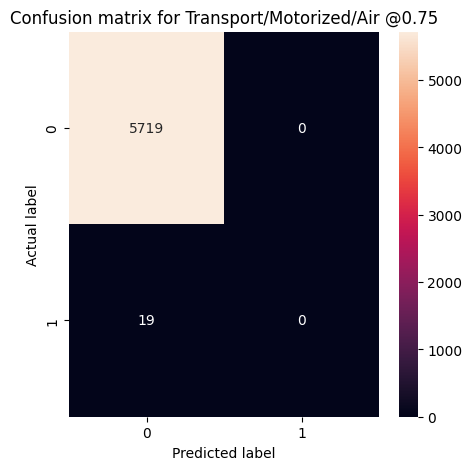

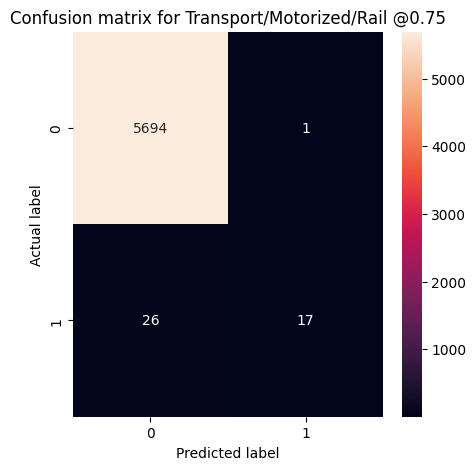

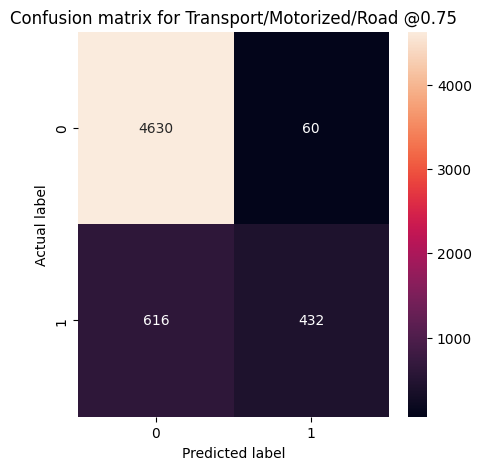

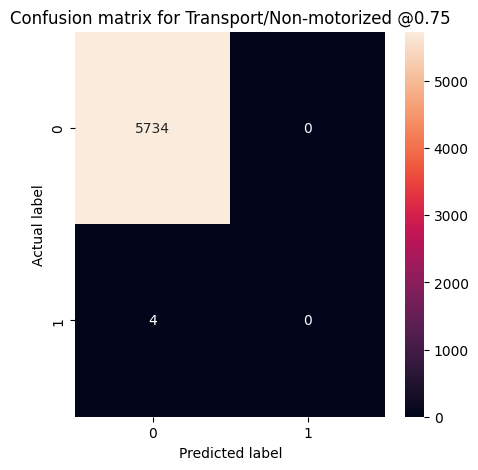

In [24]:
plot_cm(test_y, test_predictions, 0.75)

In [25]:
def class_report(class_index, labels, predictions, threshold=0.5):
  class_labels = [0 if el[class_index] == 0 else 1 for el in labels]
  labels_preds = predictions > threshold
  class_preds = [1 if el[class_index] else 0 for el in labels_preds]

  return classification_report(class_labels, class_preds, zero_division=0)

In [26]:
for i, name in enumerate(real_classes):
  print(name)
  print(class_report(i, test_y, test_predictions, threshold=0.5))

Human/Cough
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5737
           1       0.00      0.00      0.00         1

    accuracy                           1.00      5738
   macro avg       0.50      0.50      0.50      5738
weighted avg       1.00      1.00      1.00      5738

Human/Movement
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5698
           1       0.00      0.00      0.00        40

    accuracy                           0.99      5738
   macro avg       0.50      0.50      0.50      5738
weighted avg       0.99      0.99      0.99      5738

Human/Movement/Steps
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5711
           1       0.00      0.00      0.00        27

    accuracy                           1.00      5738
   macro avg       0.50      0.50      0.50      5738
weighted avg       0.99   

# Unbalanced learning

In [37]:
class_weight = {i: 1 / (len(real_classes) * el) for i, el in class_frequencies.items()}
class_weight[9] = 1   # remember we removed it
class_weight

{17: 0.09411753127245169,
 10: 0.14343567668101573,
 31: 0.17383795968079113,
 4: 0.46664714780656813,
 14: 0.5667298802892023,
 5: 1.1379105188005714,
 26: 1.1828076685219544,
 13: 1.1991222570532913,
 3: 1.7181099532878186,
 12: 2.4910132847095596,
 8: 2.708297932596998,
 6: 3.10487012987013,
 20: 3.280617495711836,
 1: 4.93956611570248,
 19: 5.5023014959723815,
 30: 6.20974025974026,
 2: 9.248549323017407,
 11: 14.251862891207153,
 28: 14.989028213166144,
 22: 15.52435064935065,
 27: 18.111742424242422,
 21: 19.75826446280992,
 7: 21.2039911308204,
 25: 25.56951871657754,
 15: 28.97878787878788,
 16: 37.79841897233202,
 29: 41.39826839826839,
 18: 43.46818181818182,
 32: 45.75598086124402,
 23: 57.95757575757576,
 0: 108.67045454545456,
 24: 434.68181818181824,
 9: 1}

In [39]:
n_splits = 1
#splitter = StratifiedKFold(n_splits=n_splits)
splitter = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2)

dropout_rate = 0.3
lr = 0.0005
patience = 15
hid_1, hid_2 = 1024, 512
epochs = 100

METRICS = [
      'accuracy'
]

# TODO check bias initialization
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics
#output_bias =
#output_bias = tf.keras.initializers.Constant(output_bias)

#results = []
#for fold, (train_ind, test_ind) in enumerate(splitter.split(x_arr, y_arr)):
fold, (train_ind, test_ind) = 0, next(splitter.split(x_arr, y_arr))

print(f"Starting fold {fold+1} out of {n_splits}")
train_x = tf.stack([x_list[i] for i in train_ind])
train_y = tf.stack([y_list_one_hot[i] for i in train_ind])
test_x = tf.stack([x_list[i] for i in test_ind])
test_y = tf.stack([y_list_one_hot[i] for i in test_ind])

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(hid_1, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(hid_2, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(len(real_classes), activation='sigmoid')#, bias_initializer=output_bias)
], name='model')
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                metrics=METRICS)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=patience,
                                            restore_best_weights=True)

history = model.fit(train_x,
                    train_y,
                    epochs=epochs,
                    validation_data=(test_x, test_y),
                    callbacks=callback,
                    class_weight=class_weight)

#results.append((model.predict(test_x), test_y))

Starting fold 1 out of 1
Epoch 1/100
718/718 [==============================] - 32s 42ms/step - loss: 0.2882 - accuracy: 0.2856 - val_loss: 0.2099 - val_accuracy: 0.3447
Epoch 2/100
718/718 [==============================] - 31s 43ms/step - loss: 0.1757 - accuracy: 0.3240 - val_loss: 0.1776 - val_accuracy: 0.3836
Epoch 3/100
718/718 [==============================] - 32s 45ms/step - loss: 0.1489 - accuracy: 0.3330 - val_loss: 0.1589 - val_accuracy: 0.3731
Epoch 4/100
718/718 [==============================] - 31s 43ms/step - loss: 0.1316 - accuracy: 0.3336 - val_loss: 0.1461 - val_accuracy: 0.3947
Epoch 5/100
718/718 [==============================] - 32s 44ms/step - loss: 0.1199 - accuracy: 0.3483 - val_loss: 0.1453 - val_accuracy: 0.3513
Epoch 6/100
718/718 [==============================] - 29s 41ms/step - loss: 0.1160 - accuracy: 0.3442 - val_loss: 0.1350 - val_accuracy: 0.3860
Epoch 7/100
718/718 [==============================] - 34s 48ms/step - loss: 0.1076 - accuracy: 0.3493 - 

In [40]:
folder = 'data/fine_tuning_results/'
model.save(folder + 'weighted_model.keras')

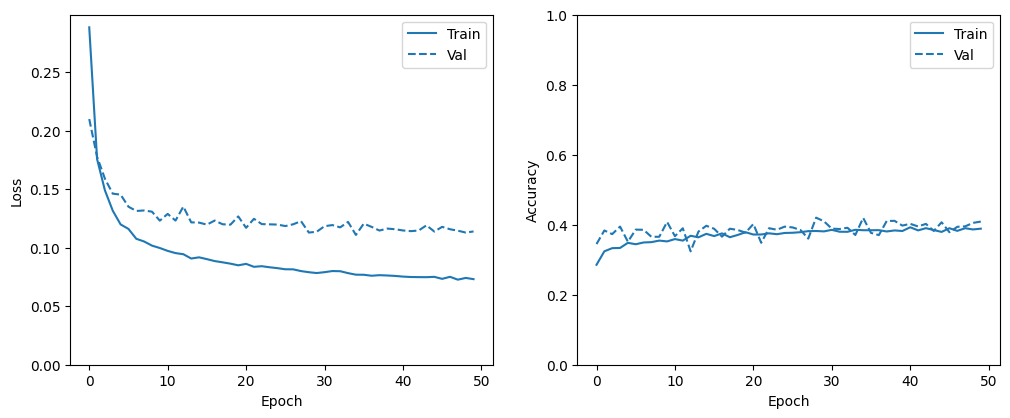

In [41]:
plot_metrics(history)

In [42]:
results = model.evaluate(test_x, test_y)

for name, value in zip(model.metrics_names, results):
  print(name, ': ', value)
print()

180/180 [==============================] - 2s 9ms/step - loss: 0.1109 - accuracy: 0.4195
loss :  0.11089135706424713
accuracy :  0.41948413848876953



In [43]:
test_predictions = model.predict(test_x)

180/180 [==============================] - 1s 6ms/step


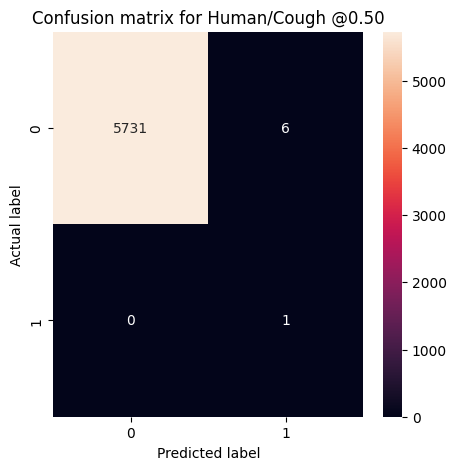

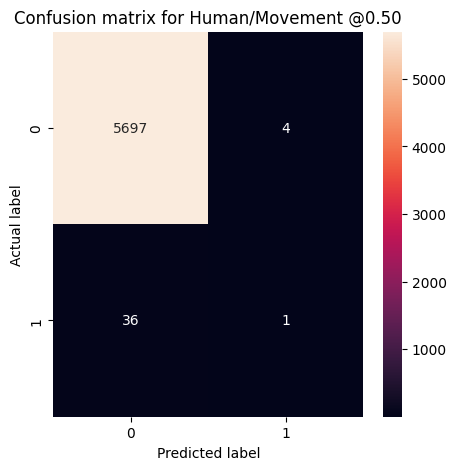

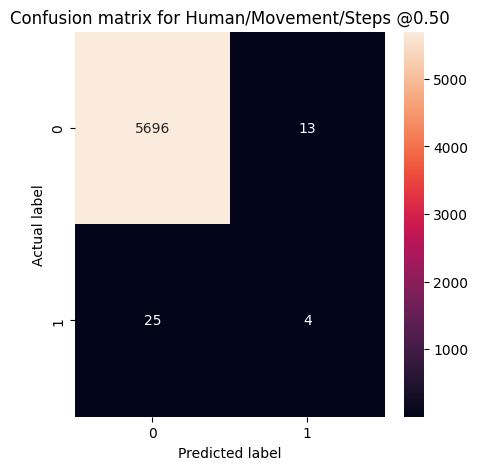

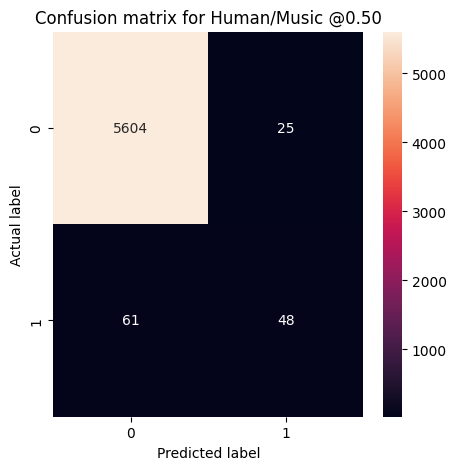

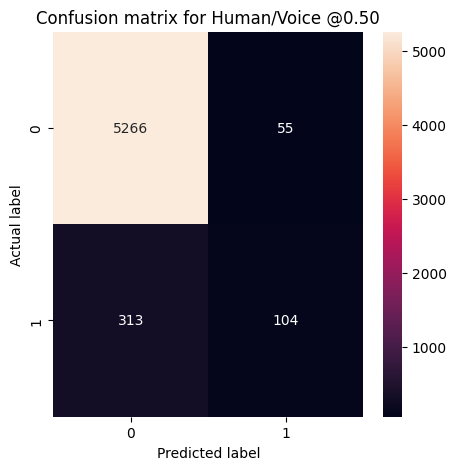

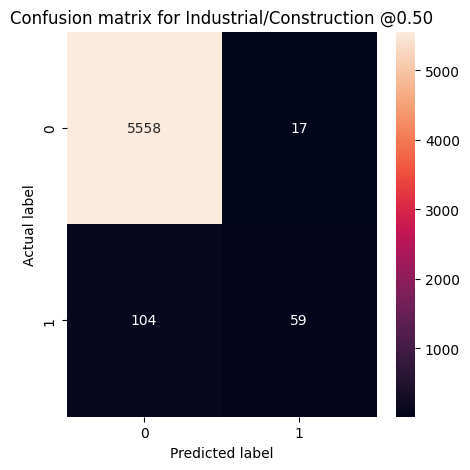

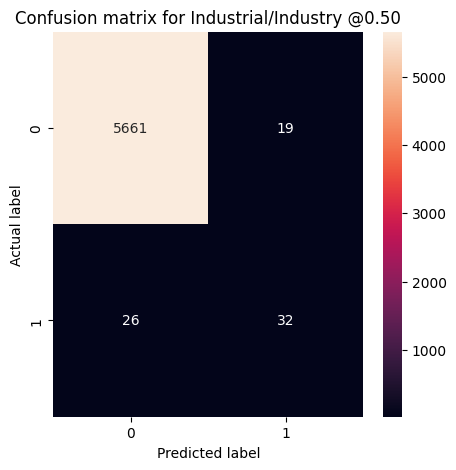

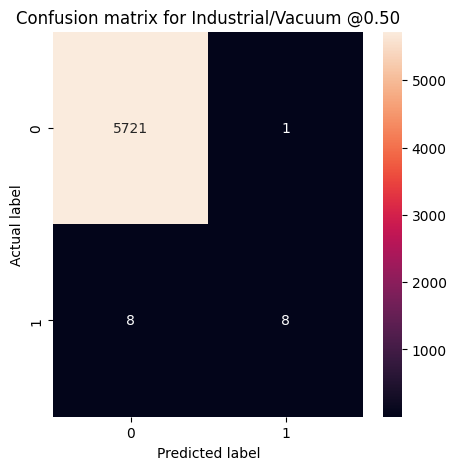

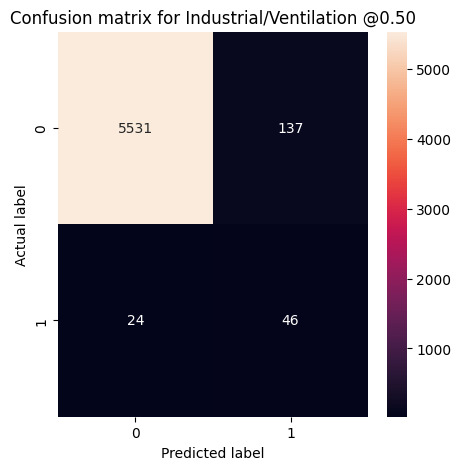

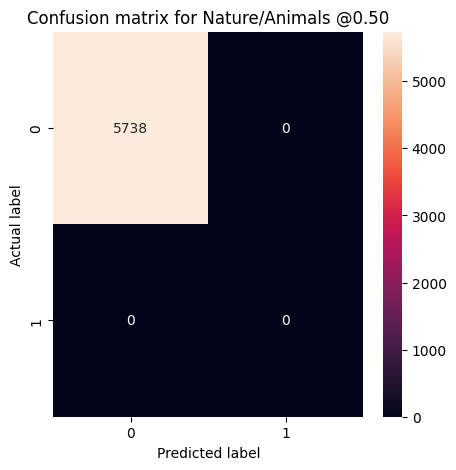

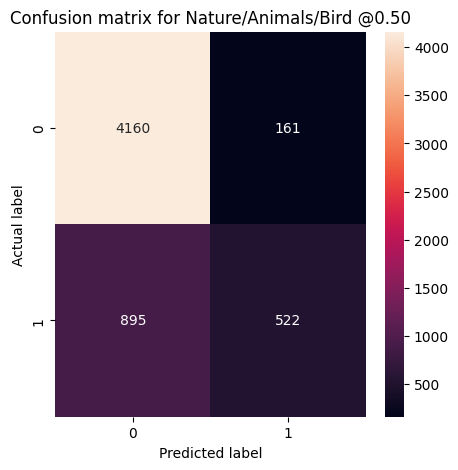

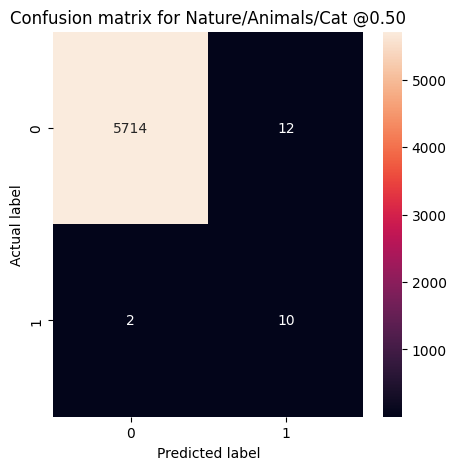

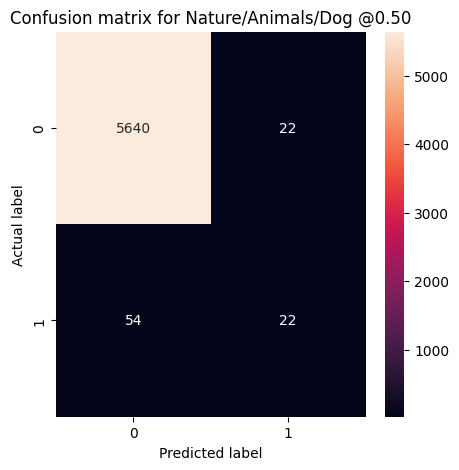

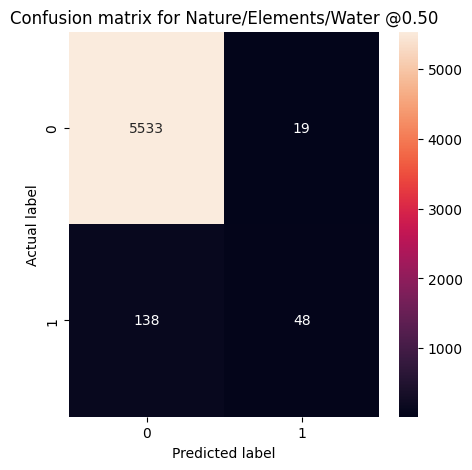

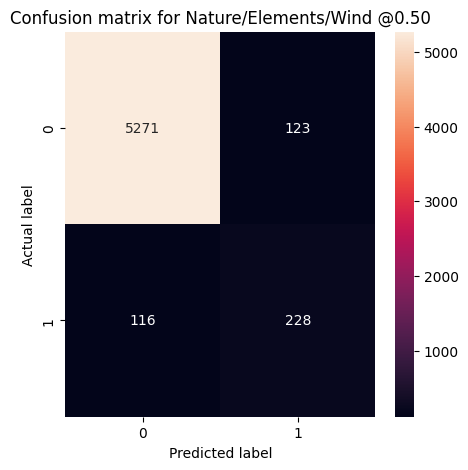

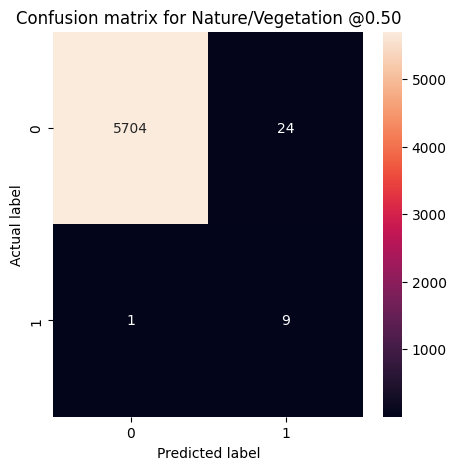

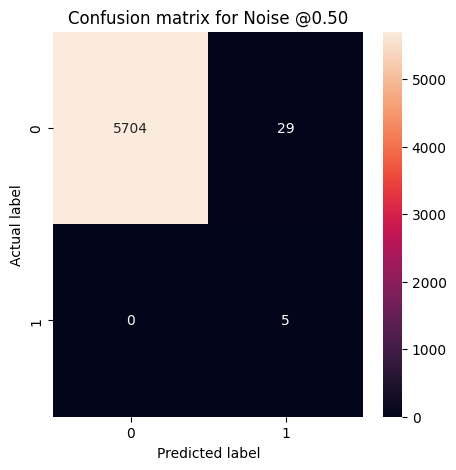

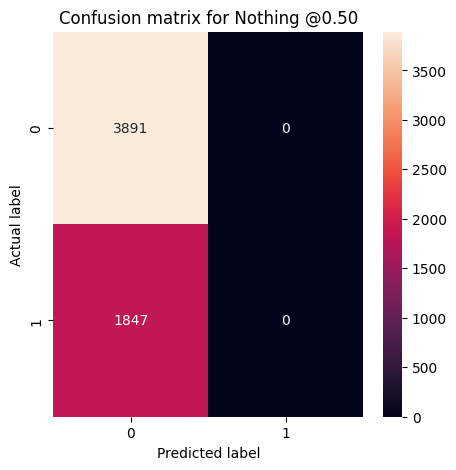

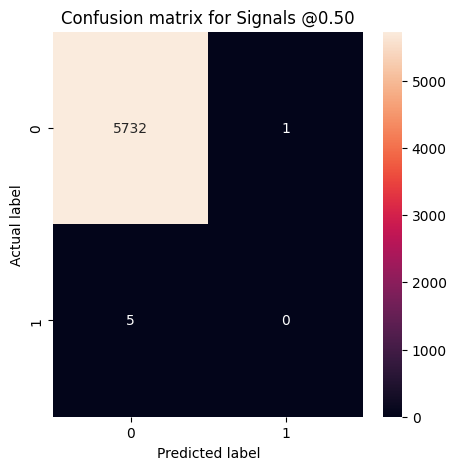

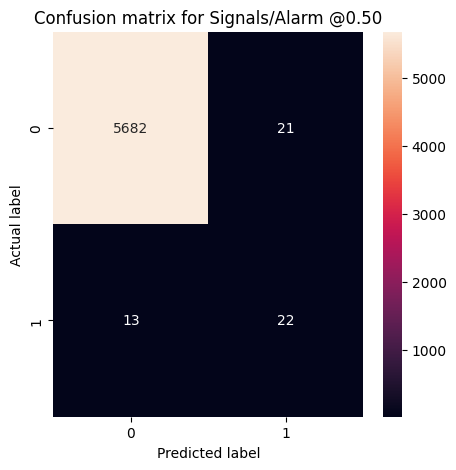

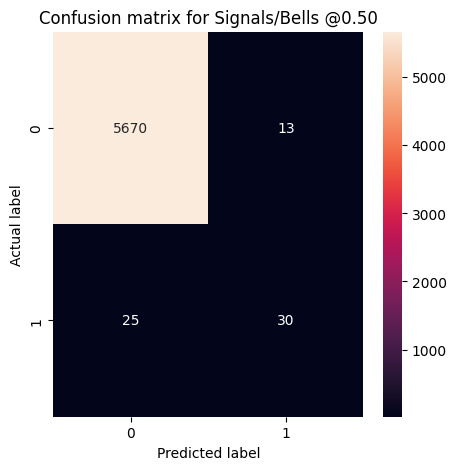

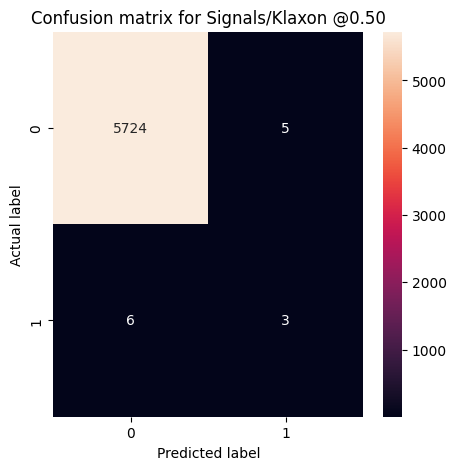

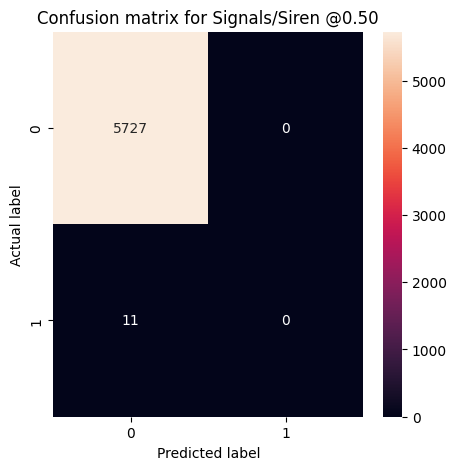

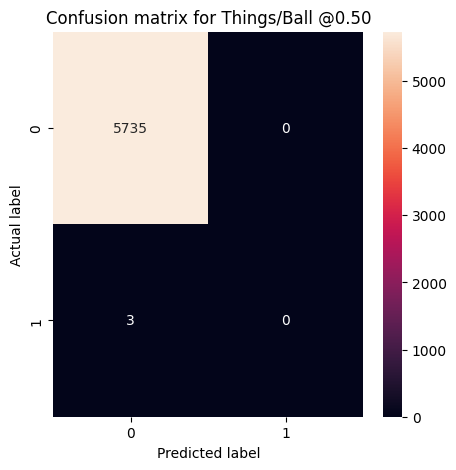

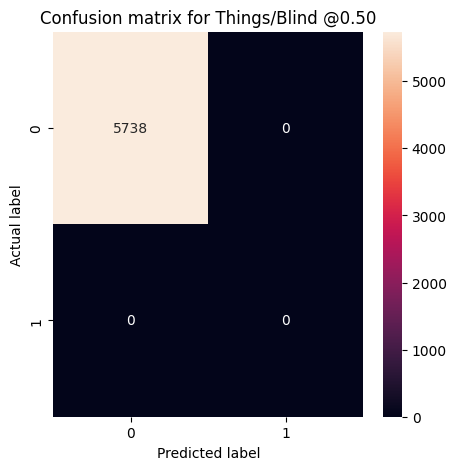

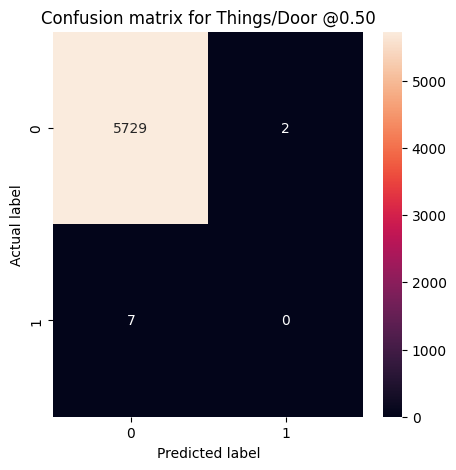

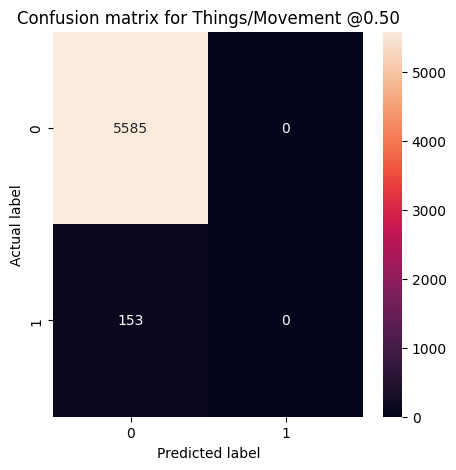

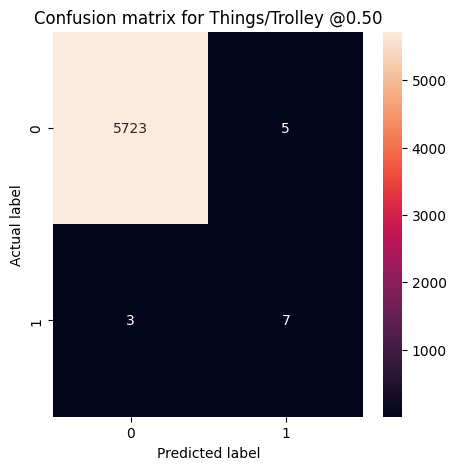

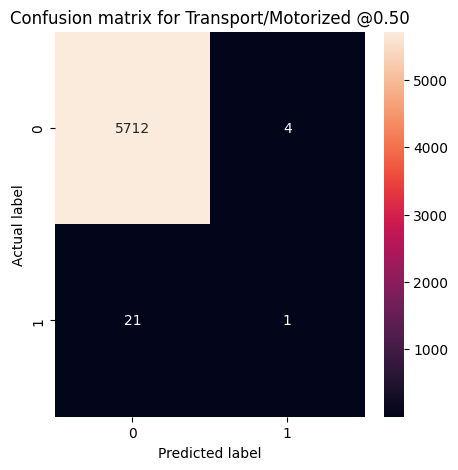

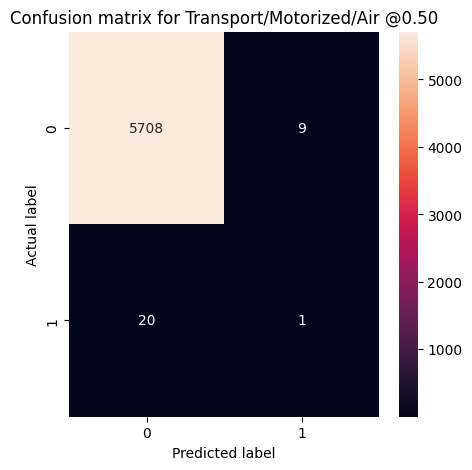

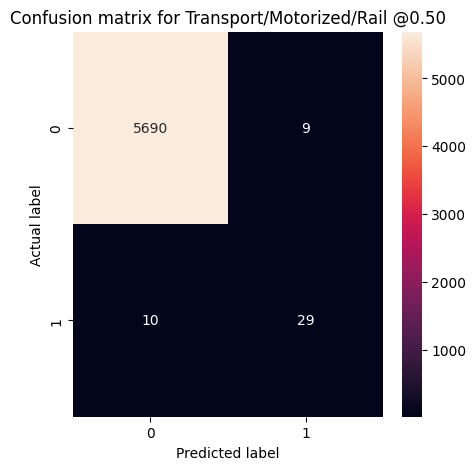

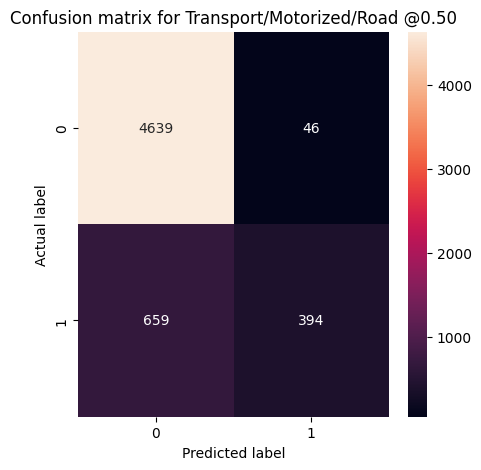

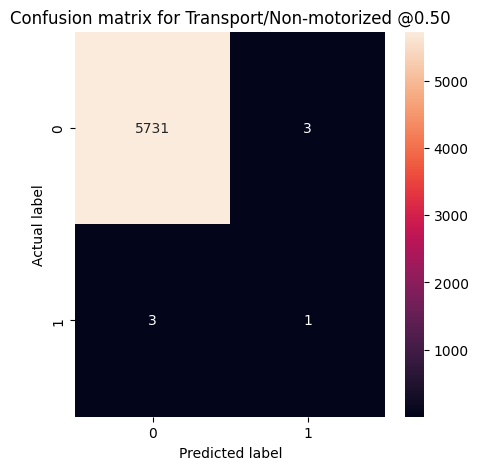

In [44]:
plot_cm(test_y, test_predictions)

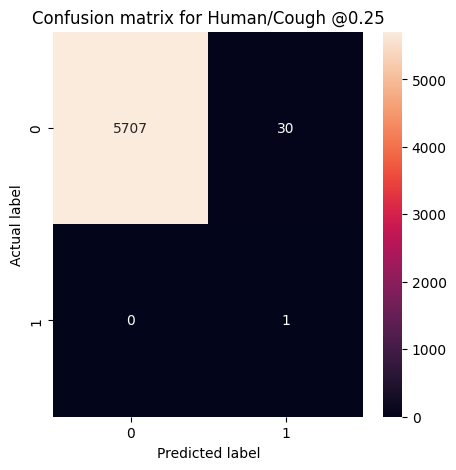

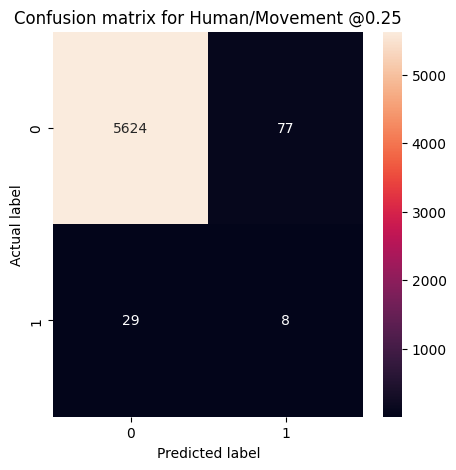

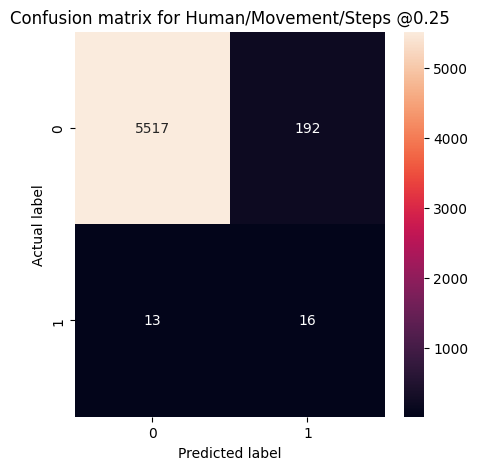

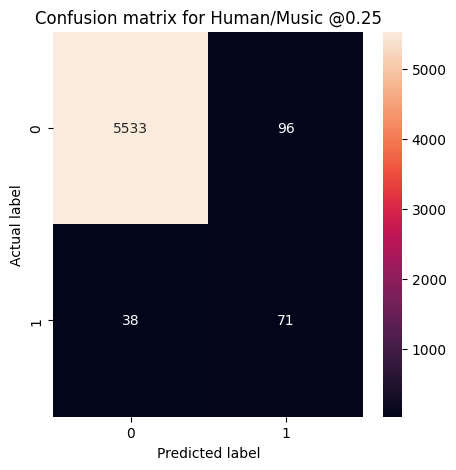

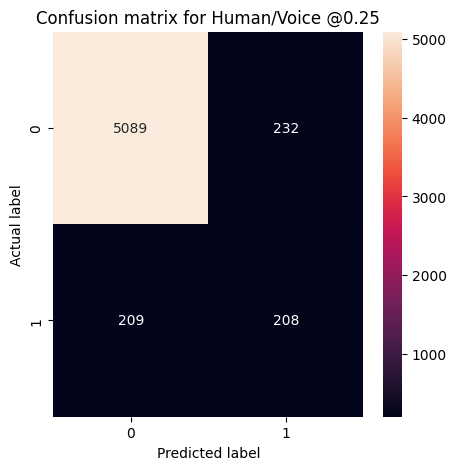

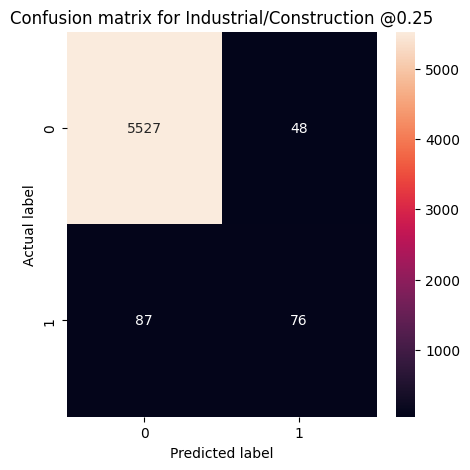

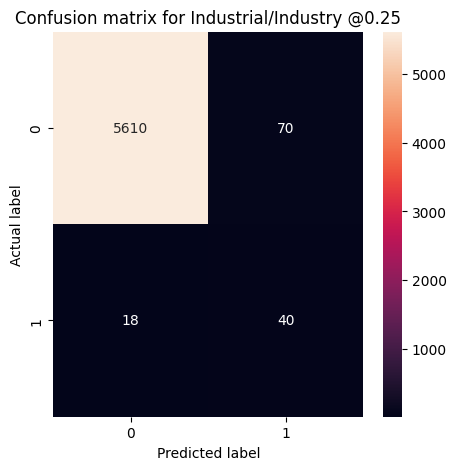

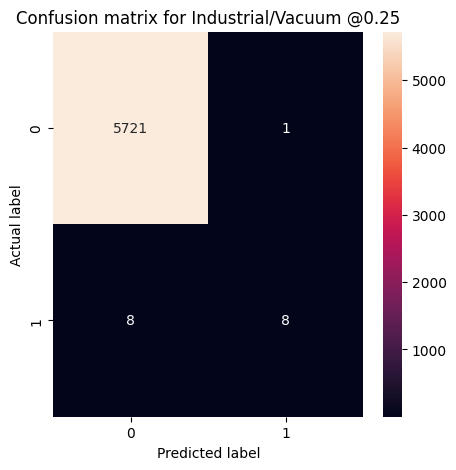

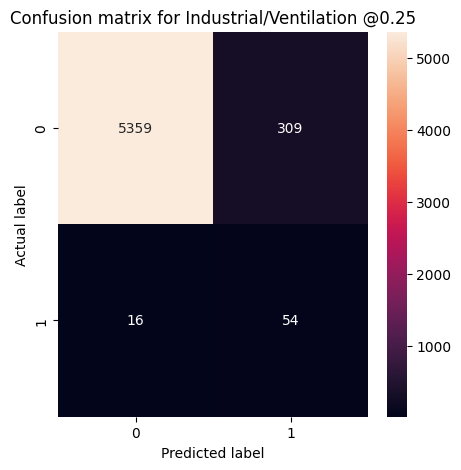

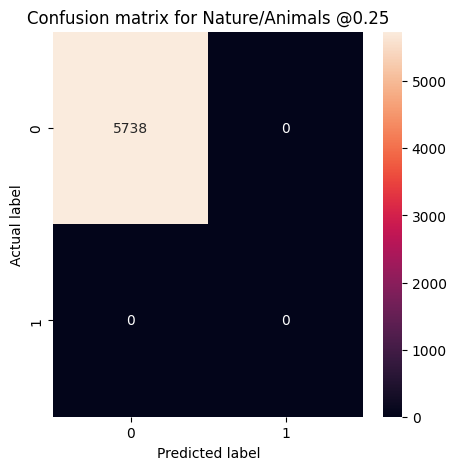

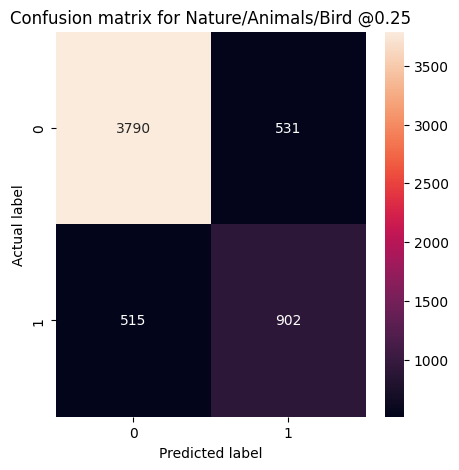

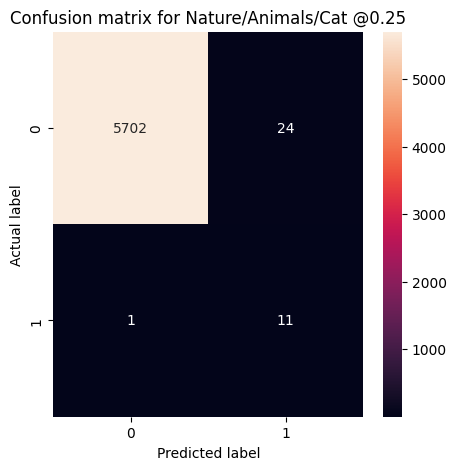

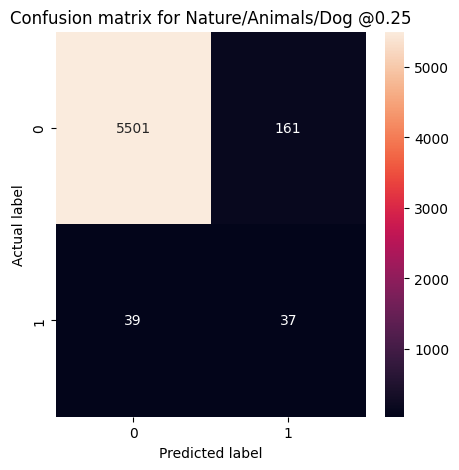

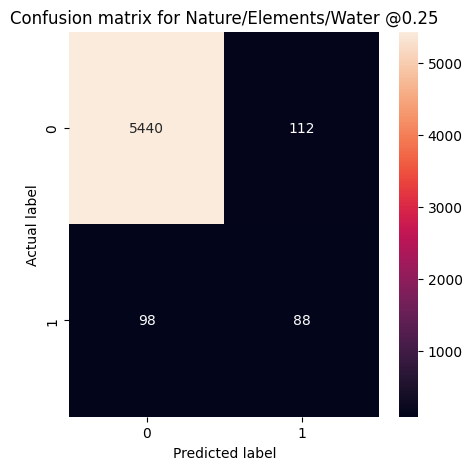

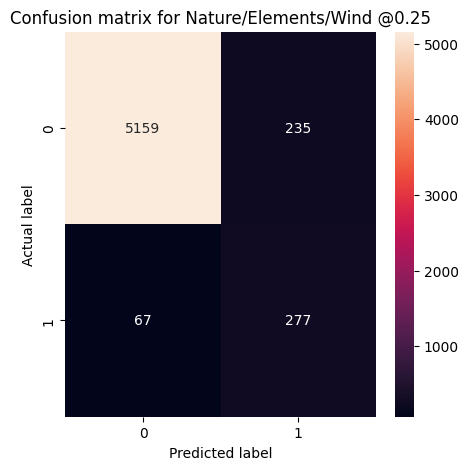

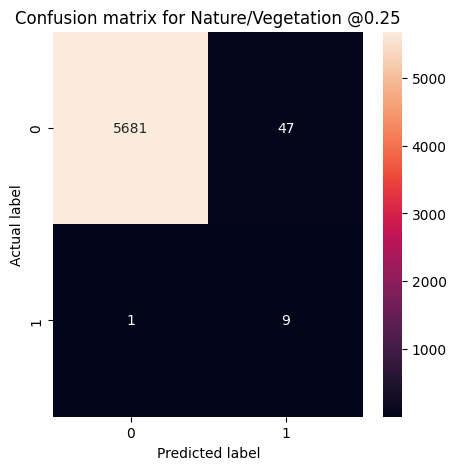

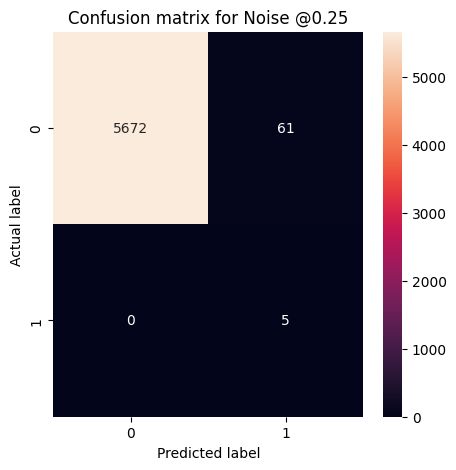

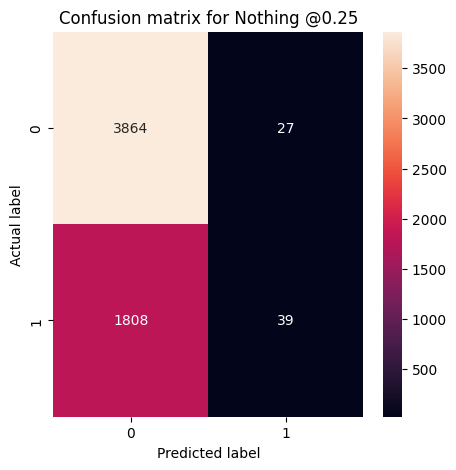

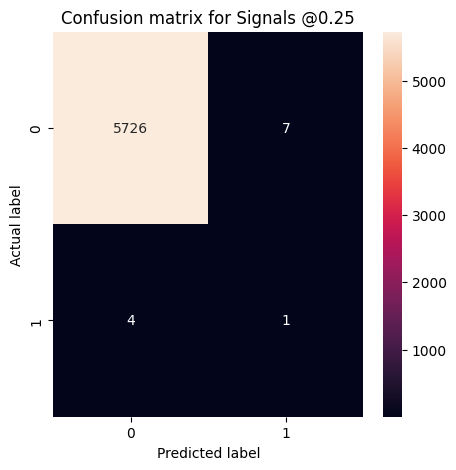

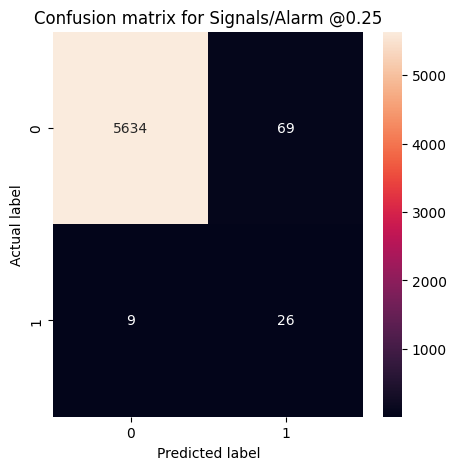

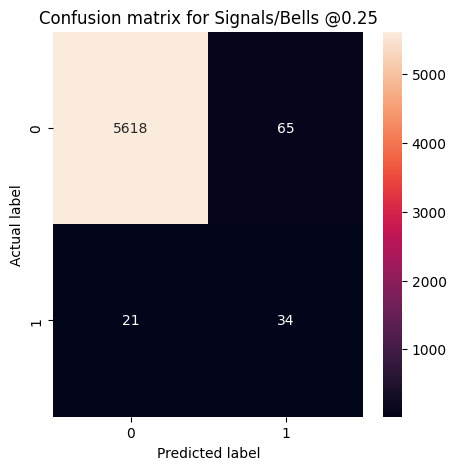

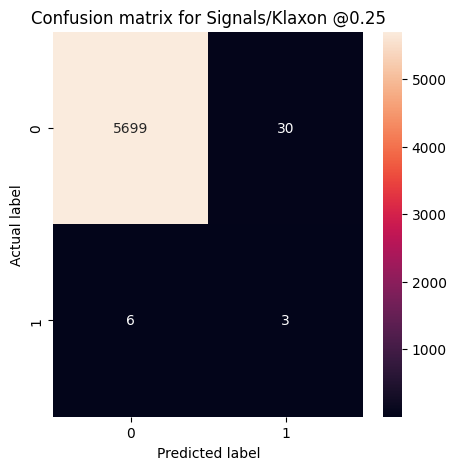

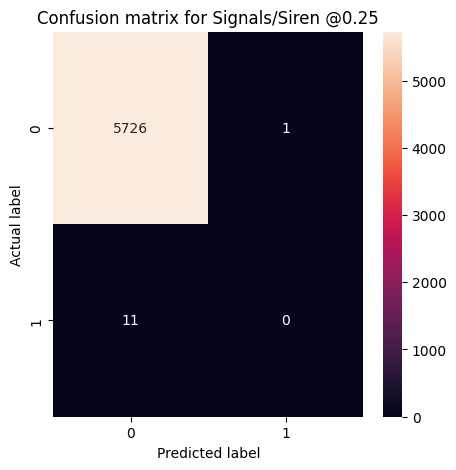

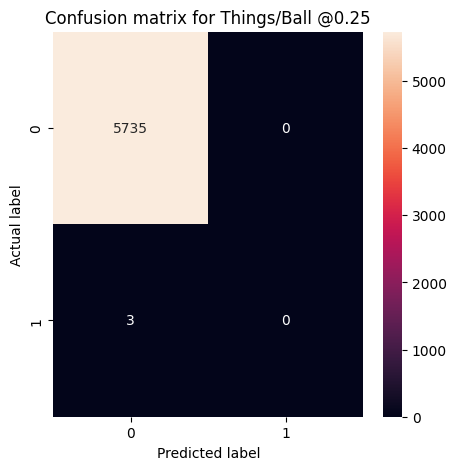

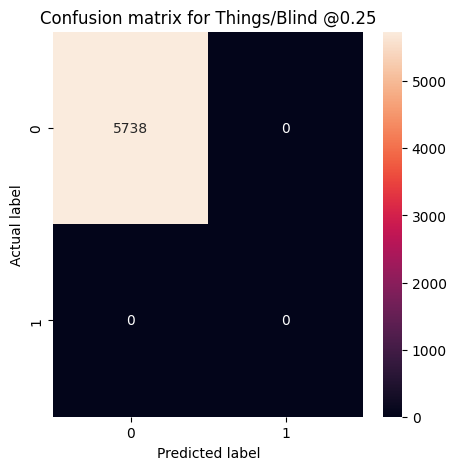

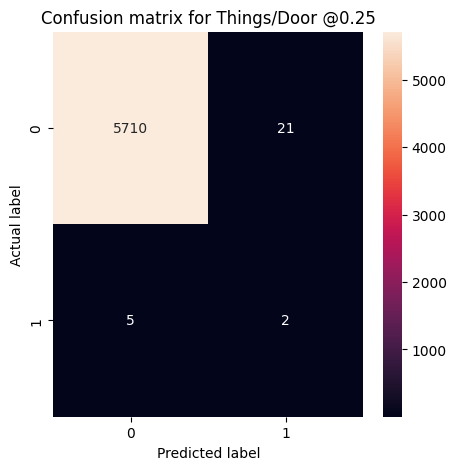

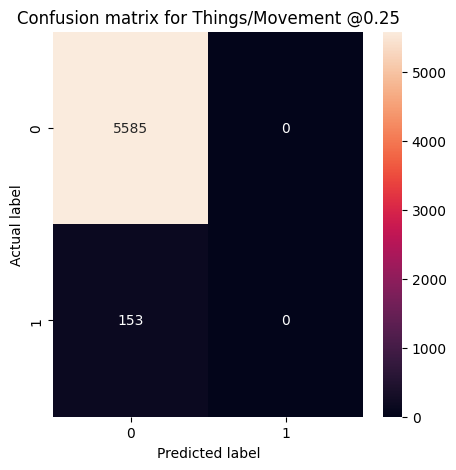

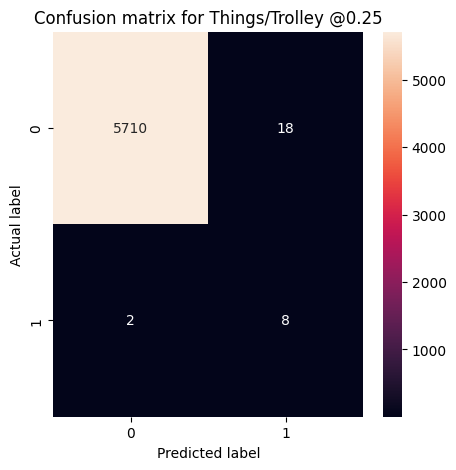

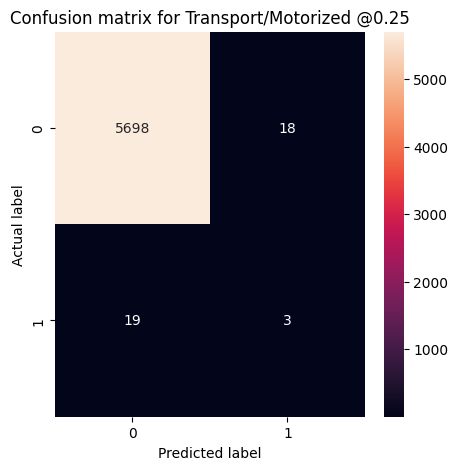

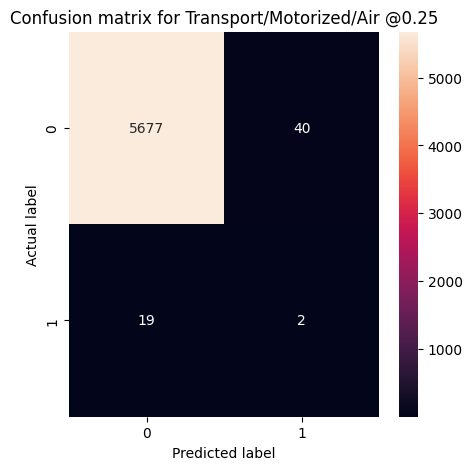

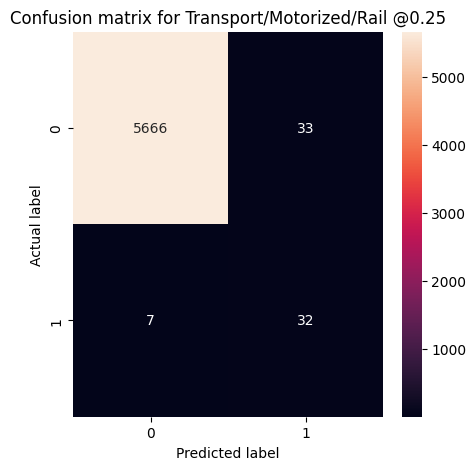

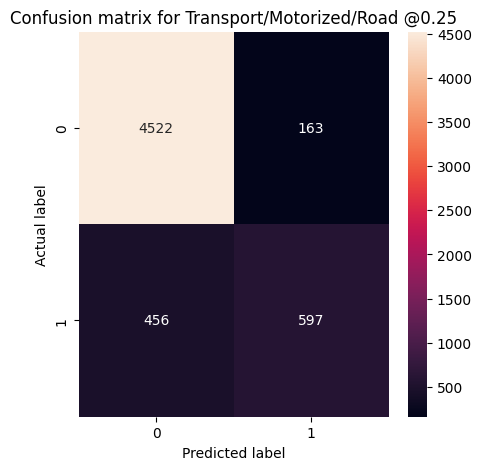

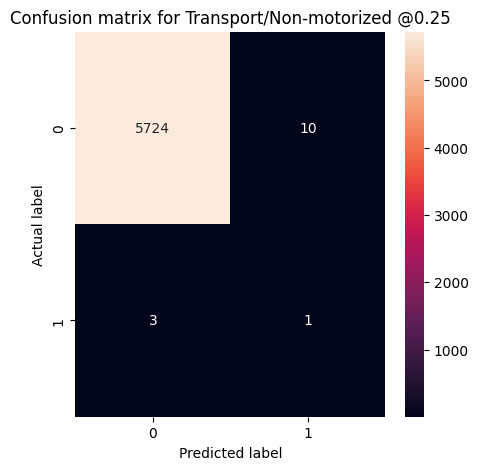

In [45]:
plot_cm(test_y, test_predictions, 0.25)

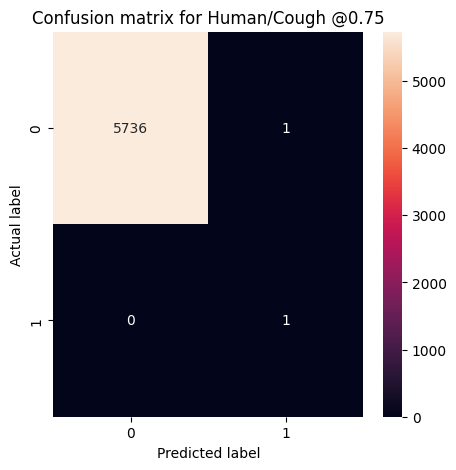

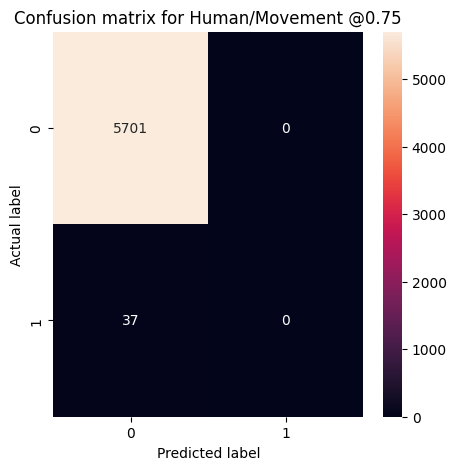

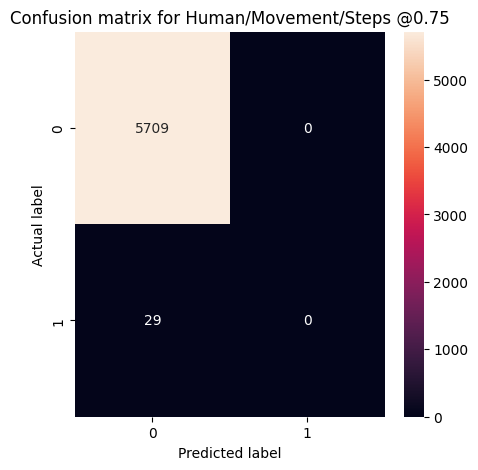

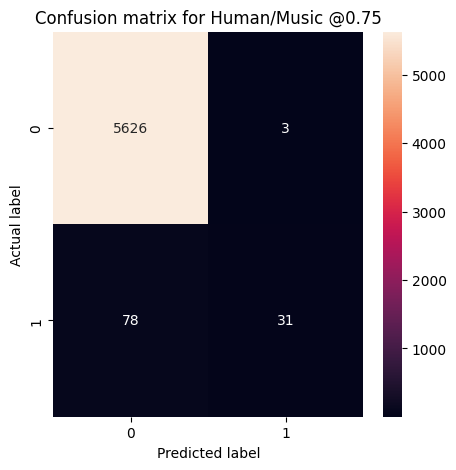

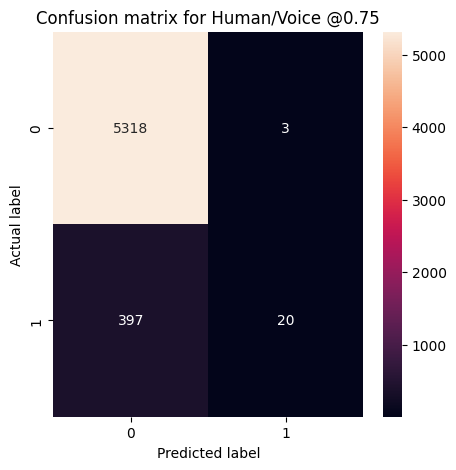

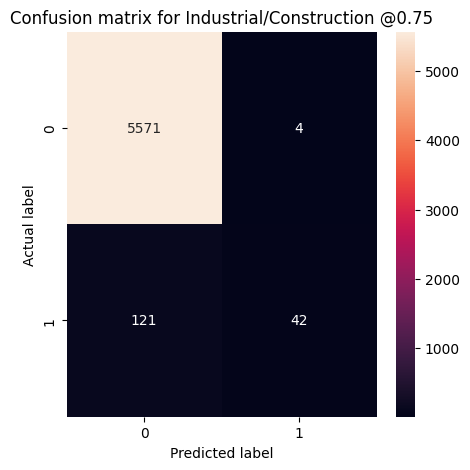

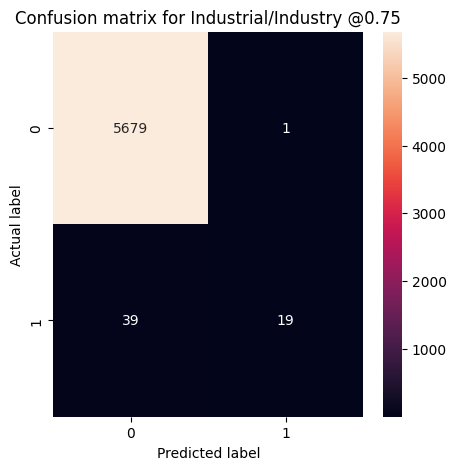

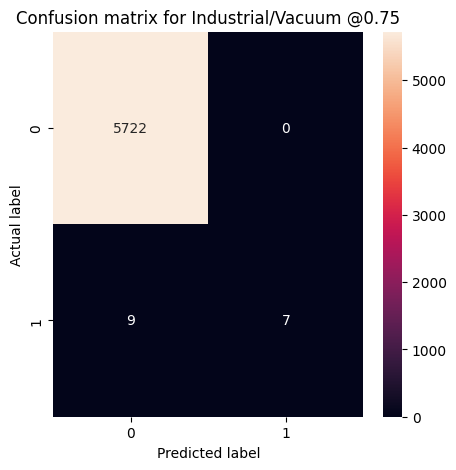

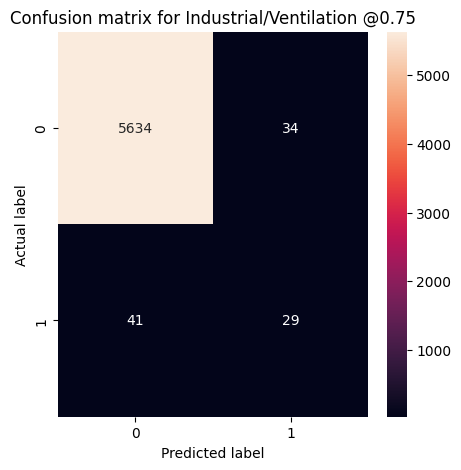

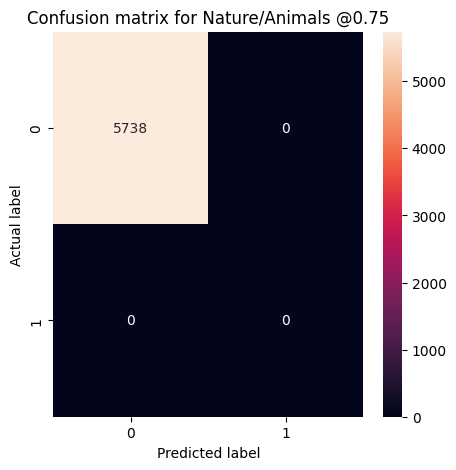

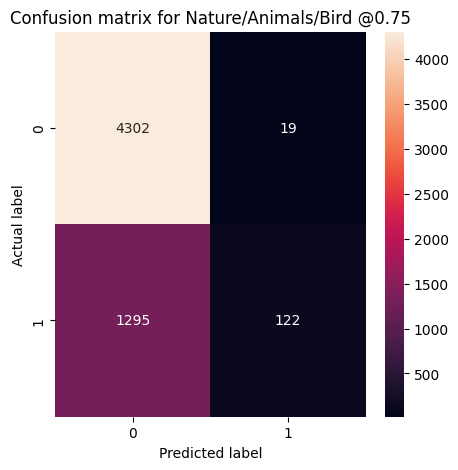

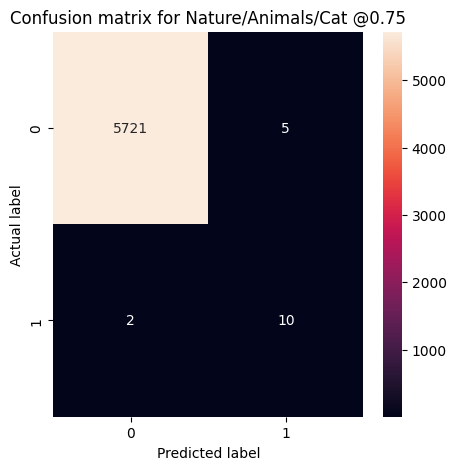

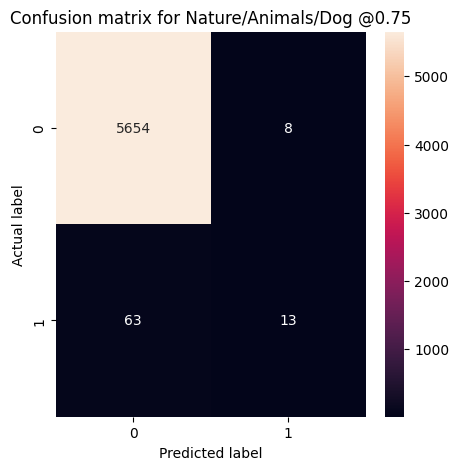

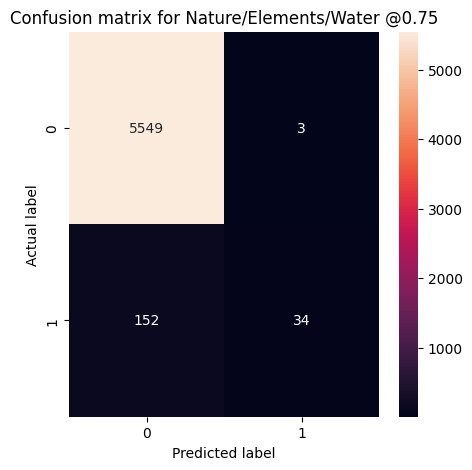

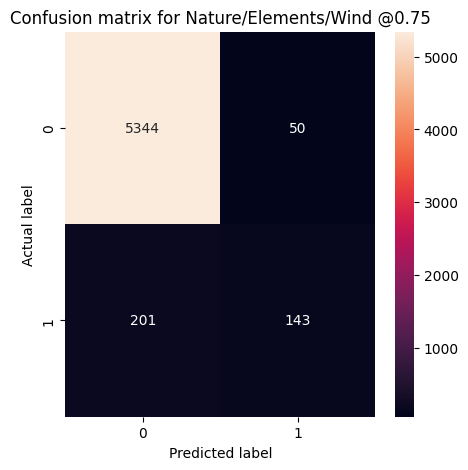

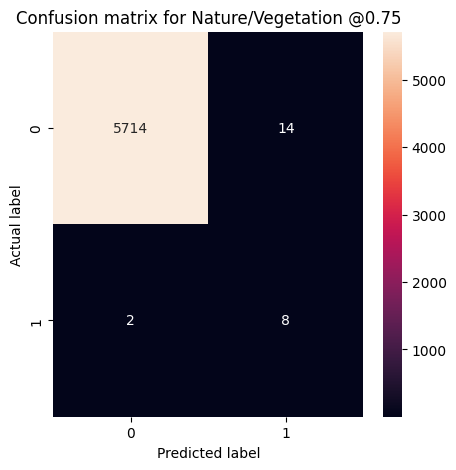

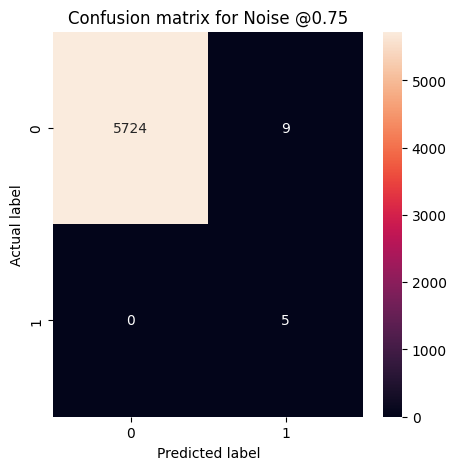

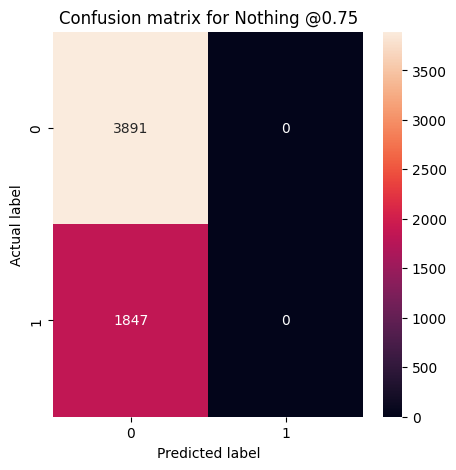

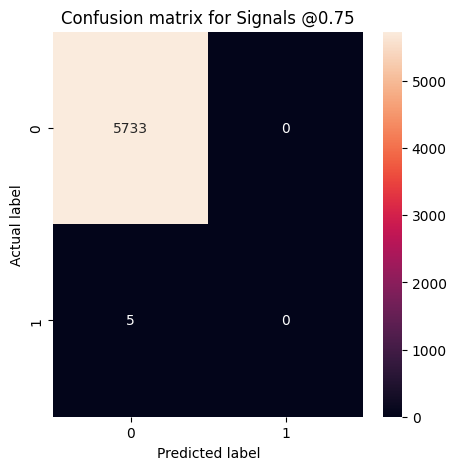

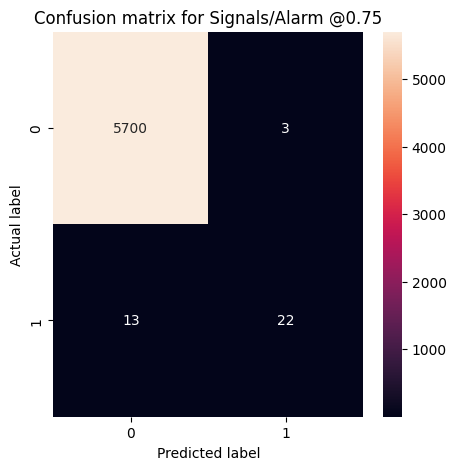

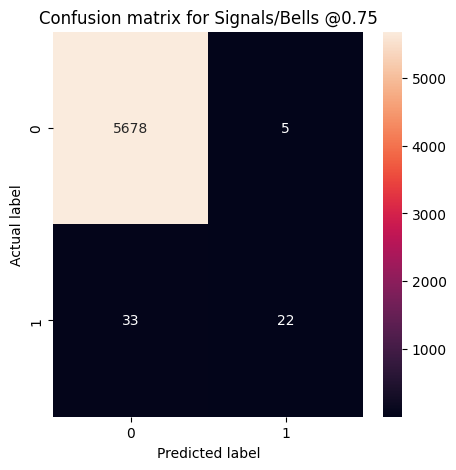

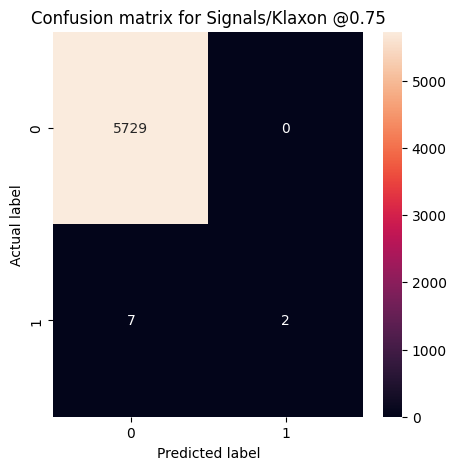

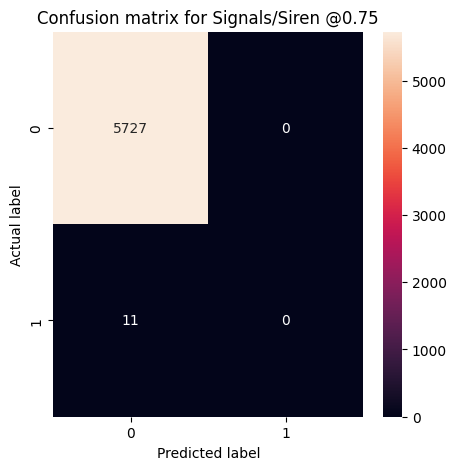

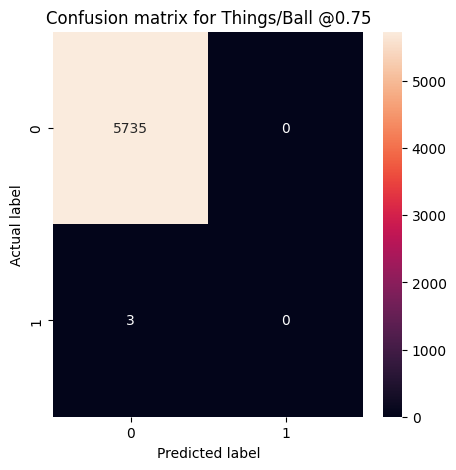

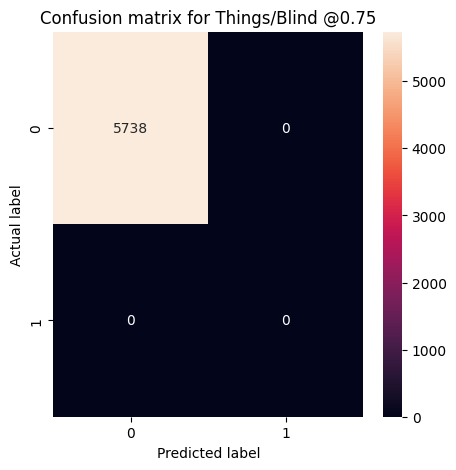

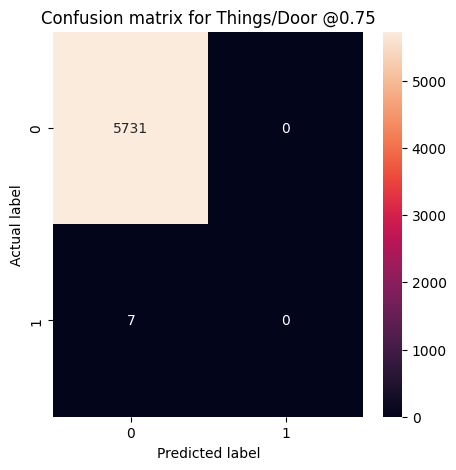

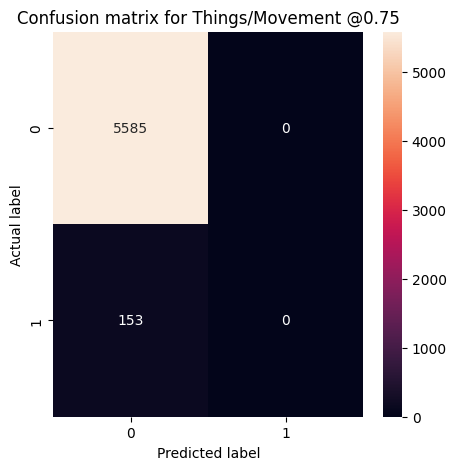

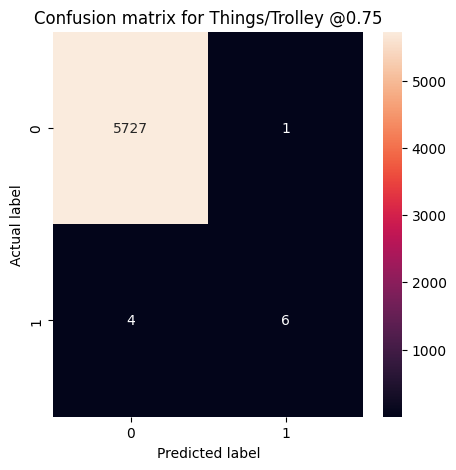

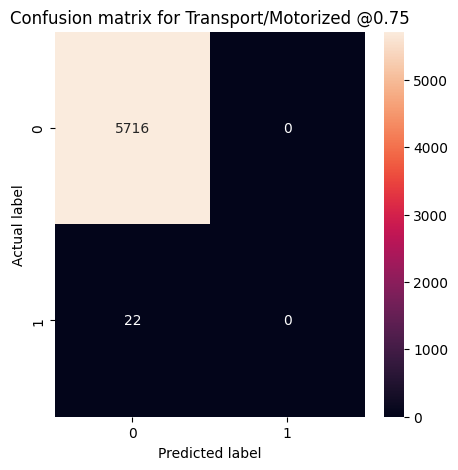

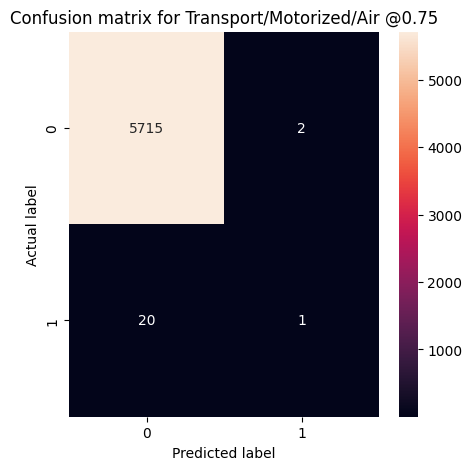

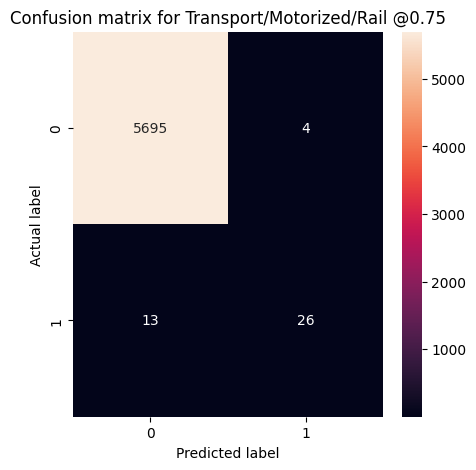

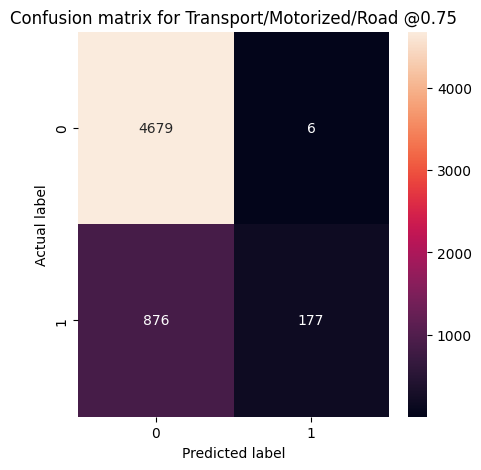

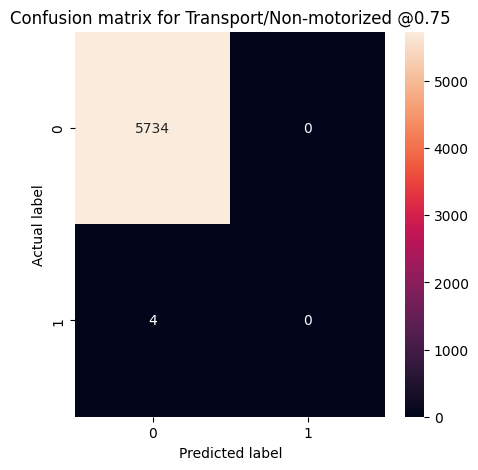

In [46]:
plot_cm(test_y, test_predictions, 0.75)

In [47]:
for i, name in enumerate(real_classes):
  print(name)
  print(class_report(i, test_y, test_predictions, threshold=0.5))

Human/Cough
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5737
           1       0.14      1.00      0.25         1

    accuracy                           1.00      5738
   macro avg       0.57      1.00      0.62      5738
weighted avg       1.00      1.00      1.00      5738

Human/Movement
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5701
           1       0.20      0.03      0.05        37

    accuracy                           0.99      5738
   macro avg       0.60      0.51      0.52      5738
weighted avg       0.99      0.99      0.99      5738

Human/Movement/Steps
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5709
           1       0.24      0.14      0.17        29

    accuracy                           0.99      5738
   macro avg       0.62      0.57      0.59      5738
weighted avg       0.99   